*Multi-task learning in Self eXplainable Deep Neural Networks*
==============================================================

***Master's thesis - code***

*Part 3 - Training and Testing*

**Author:** *Adrian Domagała*

In [2]:
%run MT_Preparatory_Code.ipynb

# Training and Testing Models

For each dataset, I will follow the workflow outlined below:
1. Preparation:

    - Creating object of Config class to store all configurations.
    - Loading and standardize data:
    
        Since the Lime library will be utilized in the subsequent sections of this study, some actions at the initial stage are directly dictated by the need for later compatibility with Lime (these steps were directly taken from the official Lime tutorials at *https://github.com/marcotcr/lime*. 
        
        For example, the Lime explainer requires numerical data, even if the features are categorical. Therefore, I transform the data using Sklearn's LabelEncoder. Simultaneously, to prevent the learning model from confusing continuous features with numerically represented categorical features, the data should be encoded using techniques such as One-hot Encoder. The encoded data will be used exclusively in the learning model; the Explainer cannot use such data to ensure that each feature is used at most once in the explanation.
        
        This leads to the creation of separate datasets with different transformations applied, and at the same time, conversion between them must be possible. I have also created a dictionary to store references between categorical feature values and their names.

2. Finding the best multilayer perceptron parameters

    - Create Optuna study to find best parameters such as number of hidden layers and number of neuron per layer.

3. Training and Testing MLP 

    - For training, the Adam optimizer with a learning rate $η = 10^{−3}$ was used, along with the ReLU activation function for the hidden layers. As loss function binary cross-entropy was employed for classification tasks and the logarithm of the hyperbolic cosine for regression tasks. Whereas for evaluation, the Accuracy and Mean Squared Error metrics were used. The network structure itself was obtained through optimization.

4. Training and Testing Linear Model

    - Training and testing Linear Regression for regression tasks or Logistic Regression for classification tasks to compare its results with the MLP.
    
5. Training and Testing STL Surogate Model

6. Training and Testing Models in MTL Approach 

7. Comparison of STL with MTL

8. Local Explainability Evaluation

    


## Auto MPG

### Preparation

#### Configuration Settings

In [148]:
auto_cfg = Config(
    folders=Folders(base="Auto/"),
    files=Files(
        data="auto_data.pkl", 
        targets="auto_targets.pkl", 
        study='Auto.plt'
    ),
    training=Training(batch_size=64, num_epochs=750, patience=24),
    tuning=Tuning(num_trials = 50),
)

#### Data Loading and Standardization

In [149]:
# Data Loading
auto_df = pd.read_pickle(auto_cfg.paths.data)

auto_cfg.features.numerical = auto_df.select_dtypes(include='number').columns.values.tolist()
auto_cfg.features.numerical_indices = [auto_df.columns.get_loc(feature) for feature in auto_cfg.features.numerical]
auto_cfg.features.categorical = auto_df.select_dtypes(include='object').columns.values.tolist()
auto_cfg.features.categorical_indices = [auto_df.columns.get_loc(feature) for feature in auto_cfg.features.categorical]
auto_cfg.features.names = auto_df.columns.values.tolist()

# Creating Dictionary 
auto_cfg.features.values_names = {}
for feature, idx in zip(auto_cfg.features.categorical, auto_cfg.features.categorical_indices):
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(auto_df[feature])
    auto_df[feature] = le.transform(auto_df[feature])
    auto_cfg.features.values_names[idx] = le.classes_
    
# Data Splitting
auto_X_train, auto_X_test, auto_y_train, auto_y_test = train_test_split(
    auto_df,
    np.array(pd.read_pickle(auto_cfg.paths.targets)), 
    test_size=0.2, 
    random_state=42
)

auto_X_eval, auto_X_test, auto_y_eval, auto_y_test = train_test_split(
    auto_X_test, 
    auto_y_test, 
    test_size=0.5, 
    random_state=42
)

# Data Scaling
auto_scaler = StandardScaler()
auto_X_train[auto_cfg.features.numerical] = auto_scaler.fit_transform(auto_X_train[auto_cfg.features.numerical]).astype(float)
auto_X_train[auto_cfg.features.categorical] = auto_X_train[auto_cfg.features.categorical].astype(float)

auto_X_eval[auto_cfg.features.numerical] = auto_scaler.transform(auto_X_eval[auto_cfg.features.numerical]).astype(float)
auto_X_eval[auto_cfg.features.categorical] = auto_X_eval[auto_cfg.features.categorical].astype(float)

auto_X_test[auto_cfg.features.numerical] = auto_scaler.transform(auto_X_test[auto_cfg.features.numerical]).astype(float)
auto_X_test[auto_cfg.features.categorical] = auto_X_test[auto_cfg.features.categorical].astype(float)

auto_scaler_y = StandardScaler()
auto_y_train = auto_scaler_y.fit_transform(auto_y_train)
auto_y_eval = auto_scaler_y.transform(auto_y_eval)
auto_y_test = auto_scaler_y.transform(auto_y_test)

# Data Encoding with reindexing to maintain uniform number of columns
auto_cfg.features.dummy = pd.get_dummies(auto_df.astype(float), columns=auto_cfg.features.categorical, dtype=float).columns 

auto_X_train_encoded = pd.get_dummies(auto_X_train, columns=auto_cfg.features.categorical, dtype=float)
auto_X_train_encoded = auto_X_train_encoded.reindex(columns=auto_cfg.features.dummy, fill_value=0.0).values

auto_X_eval_encoded = pd.get_dummies(auto_X_eval, columns=auto_cfg.features.categorical, dtype=float)
auto_X_eval_encoded = auto_X_eval_encoded.reindex(columns=auto_cfg.features.dummy, fill_value=0.0).values

auto_X_test_encoded = pd.get_dummies(auto_X_test, columns=auto_cfg.features.categorical, dtype=float)
auto_X_test_encoded = auto_X_test_encoded.reindex(columns=auto_cfg.features.dummy, fill_value=0.0).values

# Data Conversion 
auto_X_train_tensor = torch.tensor(auto_X_train_encoded, dtype=torch.float32)
auto_X_eval_tensor = torch.tensor(auto_X_eval_encoded, dtype=torch.float32)
auto_X_test_tensor = torch.tensor(auto_X_test_encoded, dtype=torch.float32)

auto_y_train_tensor = torch.tensor(auto_y_train, dtype=torch.float32)
auto_y_eval_tensor = torch.tensor(auto_y_eval, dtype=torch.float32)
auto_y_test_tensor = torch.tensor(auto_y_test, dtype=torch.float32)

auto_X_train_np = auto_X_train.values
auto_X_eval_np = auto_X_eval.values
auto_X_test_np = auto_X_test.values

# Updating Configuration 
auto_cfg.input_size = auto_X_train_tensor.shape[1]
auto_cfg.tuning.min_neurons = auto_cfg.input_size // 4 - 1
auto_cfg.tuning.max_neurons = auto_cfg.input_size * 4 + 1

### Finding Best MLP model

#### Optimization Function

In [150]:
def train_and_optimize_auto(trial, config: Config):
    print(f"Trial: {trial}")
    num_layers = trial.suggest_int(config.tuning.name_layers, config.tuning.min_layers, config.tuning.max_layers)
    hidden_sizes = [trial.suggest_int(f'{config.tuning.name_neurons}{i}', config.tuning.min_neurons, config.tuning.max_neurons) for i in range(num_layers)]

    model = MLP_reg(config.input_size, hidden_sizes, 1)

    mse = train_eval(
        data_train=auto_X_train_tensor,
        target_train=auto_y_train_tensor,
        data_eval=auto_X_eval_tensor,
        target_eval=auto_y_eval_tensor,
        model=model,
        criterion_train=LogHCos(),
        criterion_eval=MSELoss(),
        eval_func=eval_reg,
        direction='min',
        config=config
    )
    return mse

#### Model Optimization

In [151]:
def study_auto(config: Config):
    objective = partial(train_and_optimize_auto, config=config)
    study = optuna.create_study(
        study_name=config.files.study, 
        sampler=config.tuning.sampler(), 
        direction='minimize', 
    )
    study.optimize(objective, n_trials=config.tuning.num_trials, show_progress_bar=True)
    joblib.dump(study, config.paths.study)
    return study

auto_study = try_load_study(study_auto, auto_cfg)

In [160]:
auto_study.trials_dataframe().sort_values("value", ascending=True).drop(['datetime_start', 'datetime_complete'], axis=1).head(5)

,number,value,duration,params_num_layers,params_num_neurons0,params_num_neurons1,params_num_neurons2,params_num_neurons3,params_num_neurons4,state
10,10,0.054568,0 days 00:00:12.197300,1,27,NaN,NaN,NaN,NaN,COMPLETE
22,22,0.058145,0 days 00:00:07.545423,2,25,6.0,NaN,NaN,NaN,COMPLETE
12,12,0.059340,0 days 00:00:10.230299,1,29,NaN,NaN,NaN,NaN,COMPLETE
36,36,0.059360,0 days 00:00:06.956687,3,27,8.0,8.0,NaN,NaN,COMPLETE
18,18,0.060620,0 days 00:00:09.022324,2,22,5.0,NaN,NaN,NaN,COMPLETE


In [161]:
auto_cfg.best_parameters = auto_study.trials[10].params
auto_cfg.best_parameters

{'num_layers': 1, 'num_neurons0': 27}

### Training and Testing MLP

In [162]:
train_and_test_mlp_reg(
    X_train=auto_X_train_tensor, 
    y_train=auto_y_train_tensor,
    X_eval=auto_X_eval_tensor, 
    y_eval=auto_y_eval_tensor, 
    X_test=auto_X_test_tensor, 
    y_test=auto_y_test_tensor, 
    config=auto_cfg
)
print(np.mean(list(auto_cfg.results.stl_mlp.values())))
auto_cfg.results.stl_mlp

Model Auto/mlp_opt_0.pt loaded successfully
Model Auto/mlp_opt_1.pt loaded successfully
Model Auto/mlp_opt_2.pt loaded successfully
Model Auto/mlp_opt_3.pt loaded successfully
Model Auto/mlp_opt_4.pt loaded successfully
0.08718777894973755


{0: 0.08176814764738083,
 1: 0.08735443651676178,
 2: 0.0899825245141983,
 3: 0.09667001664638519,
 4: 0.08016376942396164}

### Training and Testing Linear Model

In [163]:
train_and_test_lin_reg(
    X_train=auto_X_train_tensor, 
    y_train=auto_y_train_tensor,
    X_eval=auto_X_eval_tensor, 
    y_eval=auto_y_eval_tensor, 
    X_test=auto_X_test_tensor, 
    y_test=auto_y_test_tensor, 
    config=auto_cfg
)
print(np.mean(list(auto_cfg.results.reg.values())))
auto_cfg.results.reg

Model Auto/reg_0.pt loaded successfully
Model Auto/reg_1.pt loaded successfully
Model Auto/reg_2.pt loaded successfully
Model Auto/reg_3.pt loaded successfully
Model Auto/reg_4.pt loaded successfully
0.1571510285139084


{0: 0.15720190107822418,
 1: 0.1529366374015808,
 2: 0.15897294878959656,
 3: 0.16051192581653595,
 4: 0.15613172948360443}

### Training and Testing STL Surogate Model

Train Logistic Regression to explain adult_mlp_stl model

In [164]:
train_and_test_stl_lin_reg(
    X_train=auto_X_train_tensor, 
    X_eval=auto_X_eval_tensor, 
    X_test=auto_X_test_tensor, 
    config=auto_cfg
)
print(np.mean(list(auto_cfg.results.stl_reg.values())))
auto_cfg.results.stl_reg

Model Auto/stl_reg_0.pt loaded successfully
Model Auto/stl_reg_1.pt loaded successfully
Model Auto/stl_reg_2.pt loaded successfully
Model Auto/stl_reg_3.pt loaded successfully
Model Auto/stl_reg_4.pt loaded successfully
0.12753539383411408


{0: 0.16184288263320923,
 1: 0.17768752574920654,
 2: 0.08960504084825516,
 3: 0.12596286833286285,
 4: 0.08257865160703659}

### Training and Testing Models in MTL Approach 

MLP + LinReg, alpha in the range of 0 to 1 with a step of 0.1.

In [165]:
train_and_test_mtl_reg(
    X_train=auto_X_train_tensor,
    y_train=auto_y_train_tensor,
    X_eval=auto_X_eval_tensor, 
    y_eval=auto_y_eval_tensor, 
    X_test=auto_X_test_tensor, 
    y_test=auto_y_test_tensor, 
    config=auto_cfg
)
auto_cfg.results.mtl

Model for alpha: 0.0
Model Auto/mtl_alpha_0.0_0.pt loaded successfully
Model: Auto/mtl_alpha_0.0_0.pt, MSE: 0.9539608359336853, Fidelity: 6.761484110029414e-05
Model for alpha: 0.1
Model Auto/mtl_alpha_0.1_0.pt loaded successfully
Model: Auto/mtl_alpha_0.1_0.pt, MSE: 0.1698102056980133, Fidelity: 0.00044359356979839504
Model for alpha: 0.2
Model Auto/mtl_alpha_0.2_0.pt loaded successfully
Model: Auto/mtl_alpha_0.2_0.pt, MSE: 0.14101563394069672, Fidelity: 0.0017668791115283966
Model for alpha: 0.3
Model Auto/mtl_alpha_0.3_0.pt loaded successfully
Model: Auto/mtl_alpha_0.3_0.pt, MSE: 0.12883888185024261, Fidelity: 0.0037427523639053106
Model for alpha: 0.4
Model Auto/mtl_alpha_0.4_0.pt loaded successfully
Model: Auto/mtl_alpha_0.4_0.pt, MSE: 0.11809908598661423, Fidelity: 0.00693476339802146
Model for alpha: 0.5
Model Auto/mtl_alpha_0.5_0.pt loaded successfully
Model: Auto/mtl_alpha_0.5_0.pt, MSE: 0.12420284748077393, Fidelity: 0.01342065166682005
Model for alpha: 0.6
Model Auto/mtl_alp

{0: {'0.0': Result(metrics=0.9539608359336853, fid=6.761484110029414e-05),
  '0.1': Result(metrics=0.1698102056980133, fid=0.00044359356979839504),
  '0.2': Result(metrics=0.14101563394069672, fid=0.0017668791115283966),
  '0.3': Result(metrics=0.12883888185024261, fid=0.0037427523639053106),
  '0.4': Result(metrics=0.11809908598661423, fid=0.00693476339802146),
  '0.5': Result(metrics=0.12420284748077393, fid=0.01342065166682005),
  '0.6': Result(metrics=0.08869180828332901, fid=0.02041069231927395),
  '0.7': Result(metrics=0.09960251301527023, fid=0.030141636729240417),
  '0.8': Result(metrics=0.08320994675159454, fid=0.05469496175646782),
  '0.9': Result(metrics=0.07911849021911621, fid=0.07897952198982239),
  '1.0': Result(metrics=0.08420112729072571, fid=0.7984119653701782)},
 1: {'0.0': Result(metrics=1.8029098510742188, fid=0.00010765386832645163),
  '0.1': Result(metrics=0.17589060962200165, fid=0.0008016612264327705),
  '0.2': Result(metrics=0.1447131186723709, fid=0.002092905

### Comparison of STL with MTL

In [228]:
auto_cfg.metrics_label='MSE'
show_tables(auto_cfg) 

Metrics,Dataset,Linear,Non-linear (MLP)
MSE,Auto,"0,1572","0,0872"


Metrics,Dataset,Linear,STL,MTL a= 0.0,MTL a= 0.1,MTL a= 0.2,MTL a= 0.3,MTL a= 0.4,MTL a= 0.5,MTL a= 0.6,MTL a= 0.7,MTL a= 0.8,MTL a= 0.9,MTL a= 1.0
MSE,Auto,"0,1572","0,0872","1,1589","0,1601","0,1459","0,1415","0,1280","0,1144","0,0933","0,0927","0,0849","0,0827","0,0962"
Global Fidelity,Auto,-,"0,1275","0,0001","0,0006","0,0016","0,0032","0,0073","0,0128","0,0211","0,0319","0,0538","0,0831","1,5249"


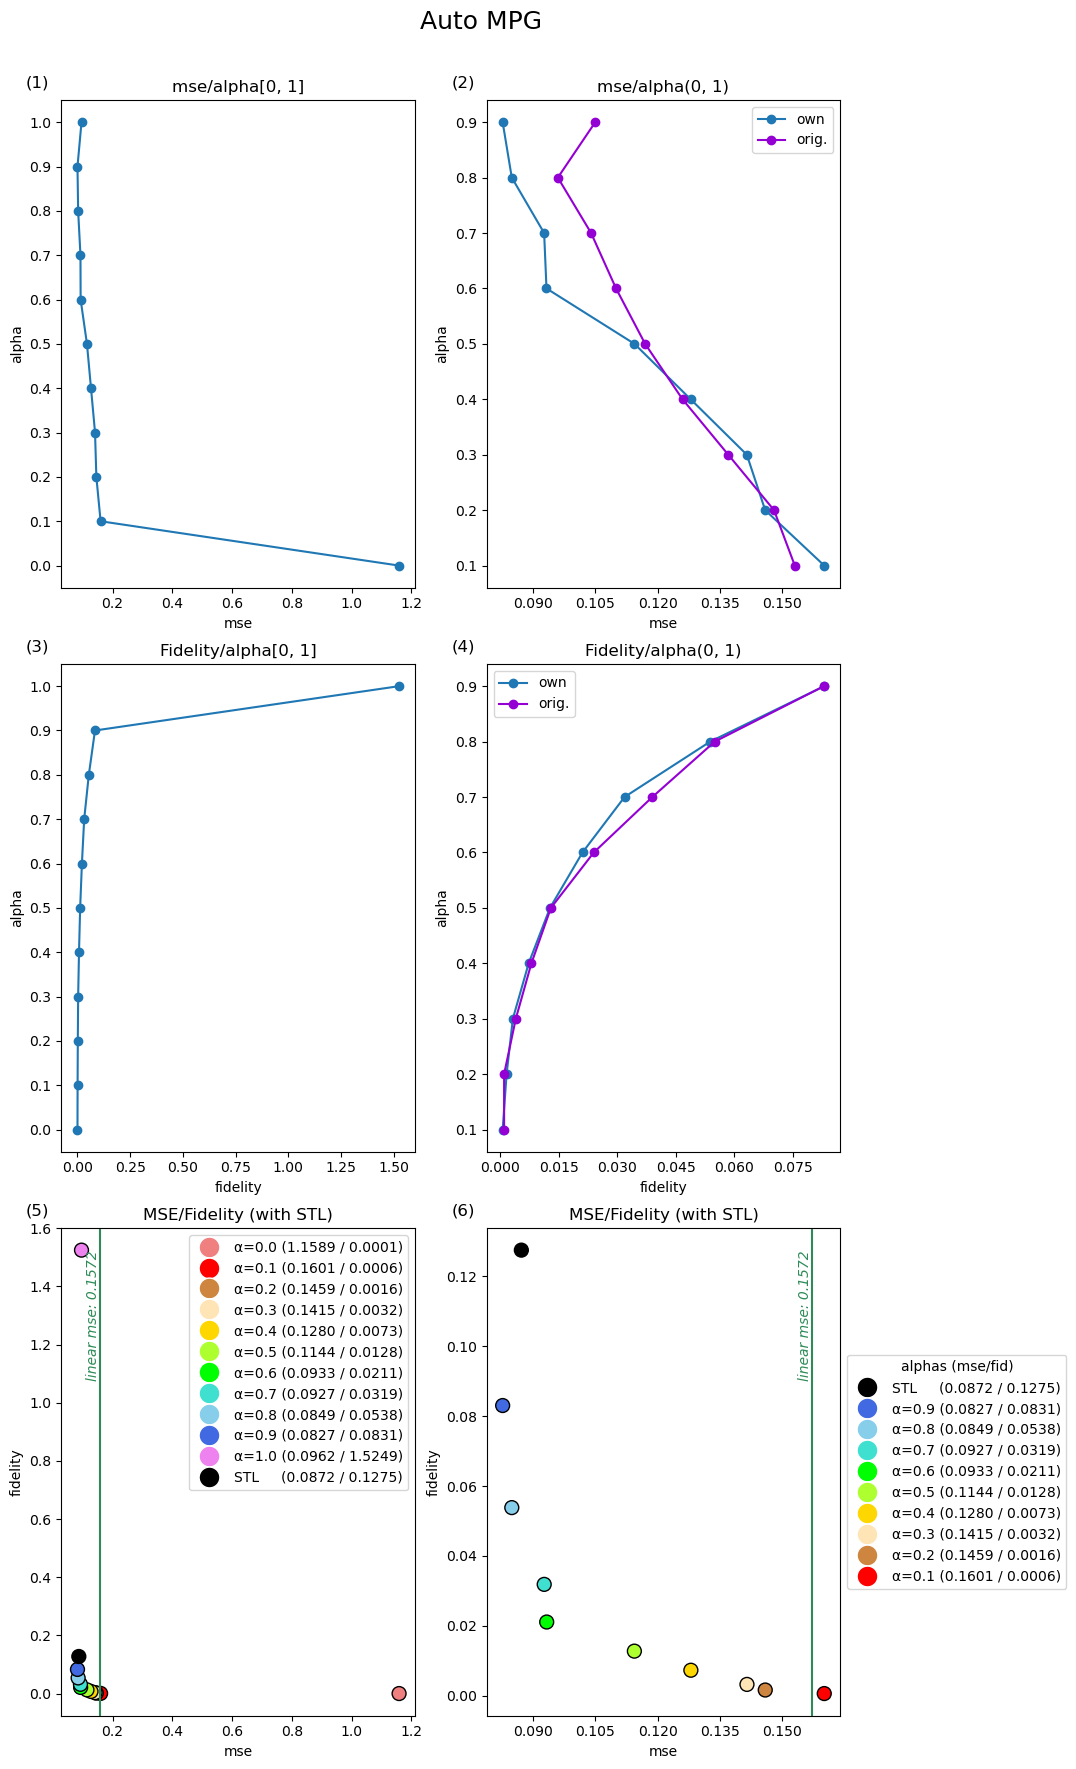

In [450]:
auto_org_results_met = [0.153, 0.148, 0.137, 0.126, 0.117, 0.110, 0.104, 0.096, 0.105]
auto_org_results_gf = [0.001, 0.001, 0.004, 0.008, 0.013, 0.024, 0.039, 0.055, 0.083]

draw_plots_MTL_vs_STL(
    metrics_label='mse',
    metrics_title='MSE',
    config=auto_cfg,
    org_met=auto_org_results_met,
    org_fid=auto_org_results_gf,
    title='Auto MPG'
)

### Local Explainability Evaluation

Creating Explainer

In [230]:
auto_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=auto_X_train_np,
    mode='regression',
    feature_names=auto_cfg.features.names,
    verbose=False,
    class_names=['MPG'],
    categorical_features=auto_cfg.features.categorical_indices,
    categorical_names=auto_cfg.features.values_names,
    discretize_continuous = False
)
auto_explainer

Global Neighborhood Fidelity for STL MLP

In [232]:
# load model
mlp = MLP_reg(input_size=auto_cfg.input_size, hidden_sizes=MLP_reg.get_hidden_sizes(auto_cfg.best_parameters, auto_cfg)).to(auto_cfg.device)
mlp.load_state_dict(torch.load(auto_cfg.models.mlp_opt + '0' + auto_cfg.models.ext))

# prediction function
auto_predict_lime = partial(predict_reg_for_lime, model=mlp, config=auto_cfg)

# neighbors dataset
print(auto_X_test_np.shape)


auto_cfg.results.stl_gnf = global_neighborhood_fidelity_reg(
    model=mlp,
    neighbors_dataset=auto_X_test_np,
    explainer=auto_explainer,
    config=auto_cfg,
    predict_func_lime=auto_predict_lime,
    predict_func_model=predict_reg_for_lime,
    n=auto_cfg.num
)
auto_cfg.results.stl_gnf

(40, 7)


[tensor(0.1842, dtype=torch.float64),
 tensor(0.1881, dtype=torch.float64),
 tensor(0.1808, dtype=torch.float64),
 tensor(0.1883, dtype=torch.float64),
 tensor(0.1957, dtype=torch.float64)]

Global Neighborhood Fidelity for MTL

In [237]:
gnf_mtl_reg_n_times(
    neighbors_dataset=auto_X_test_np,
    explainer=auto_explainer,
    model_params=auto_cfg.best_parameters,
    config=auto_cfg,
    n=auto_cfg.num
)

auto_cfg.results.mtl_gnf

Model for alpha: 0.0
Model: Auto/mtl_alpha_0.0_0.pt, GNF: [tensor(0.0289, dtype=torch.float64)]
Model for alpha: 0.1
Model: Auto/mtl_alpha_0.1_0.pt, GNF: [tensor(0.0466, dtype=torch.float64)]
Model for alpha: 0.2
Model: Auto/mtl_alpha_0.2_0.pt, GNF: [tensor(0.0691, dtype=torch.float64)]
Model for alpha: 0.3
Model: Auto/mtl_alpha_0.3_0.pt, GNF: [tensor(0.0691, dtype=torch.float64)]
Model for alpha: 0.4
Model: Auto/mtl_alpha_0.4_0.pt, GNF: [tensor(0.0739, dtype=torch.float64)]
Model for alpha: 0.5
Model: Auto/mtl_alpha_0.5_0.pt, GNF: [tensor(0.0563, dtype=torch.float64)]
Model for alpha: 0.6
Model: Auto/mtl_alpha_0.6_0.pt, GNF: [tensor(0.1097, dtype=torch.float64)]
Model for alpha: 0.7
Model: Auto/mtl_alpha_0.7_0.pt, GNF: [tensor(0.0862, dtype=torch.float64)]
Model for alpha: 0.8
Model: Auto/mtl_alpha_0.8_0.pt, GNF: [tensor(0.1305, dtype=torch.float64)]
Model for alpha: 0.9
Model: Auto/mtl_alpha_0.9_0.pt, GNF: [tensor(0.1471, dtype=torch.float64)]
Model for alpha: 1.0
Model: Auto/mtl_alp

{0: {'0.0': [tensor(0.0289, dtype=torch.float64)],
  '0.1': [tensor(0.0466, dtype=torch.float64)],
  '0.2': [tensor(0.0691, dtype=torch.float64)],
  '0.3': [tensor(0.0691, dtype=torch.float64)],
  '0.4': [tensor(0.0739, dtype=torch.float64)],
  '0.5': [tensor(0.0563, dtype=torch.float64)],
  '0.6': [tensor(0.1097, dtype=torch.float64)],
  '0.7': [tensor(0.0862, dtype=torch.float64)],
  '0.8': [tensor(0.1305, dtype=torch.float64)],
  '0.9': [tensor(0.1471, dtype=torch.float64)],
  '1.0': [tensor(0.1514, dtype=torch.float64)]},
 1: {'0.0': [tensor(0.0283, dtype=torch.float64)],
  '0.1': [tensor(0.0479, dtype=torch.float64)],
  '0.2': [tensor(0.0674, dtype=torch.float64)],
  '0.3': [tensor(0.0626, dtype=torch.float64)],
  '0.4': [tensor(0.0777, dtype=torch.float64)],
  '0.5': [tensor(0.0499, dtype=torch.float64)],
  '0.6': [tensor(0.1268, dtype=torch.float64)],
  '0.7': [tensor(0.0843, dtype=torch.float64)],
  '0.8': [tensor(0.1335, dtype=torch.float64)],
  '0.9': [tensor(0.1373, dtype=to

In [244]:
show_tables_lime(auto_cfg) 

Metric,Dataset,Linear,STL,MTL a= 0.0,MTL a= 0.1,MTL a= 0.2,MTL a= 0.3,MTL a= 0.4,MTL a= 0.5,MTL a= 0.6,MTL a= 0.7,MTL a= 0.8,MTL a= 0.9,MTL a= 1.0
GNF,Auto,-,"0,187","0,029","0,046","0,071","0,063","0,072","0,056","0,115","0,087","0,134","0,141","0,151"
MSE,Auto,"0,157","0,082","0,954","0,170","0,141","0,129","0,118","0,124","0,089","0,100","0,083","0,079","0,084"


## California Housing

### Preparation

#### Configuration Settings

In [171]:
housing_cfg = Config(
    folders=Folders(base="Housing/"),
    files=Files(
        data="housing_data.pkl", 
        targets="housing_targets.pkl", 
        study='Housing.plt'
    ),
    training=Training(batch_size=64, num_epochs=250, patience=12),
    tuning=Tuning(num_trials = 25),
)

#### Data Loading and Standardization

In [172]:
# Data Loading
housing_df = pd.read_pickle(housing_cfg.paths.data)

housing_cfg.features.numerical = housing_df.select_dtypes(include='number').columns.values.tolist()
housing_cfg.features.numerical_indices = [housing_df.columns.get_loc(feature) for feature in housing_cfg.features.numerical]
housing_cfg.features.categorical = housing_df.select_dtypes(include='object').columns.values.tolist()
housing_cfg.features.categorical_indices = [housing_df.columns.get_loc(feature) for feature in housing_cfg.features.categorical]
housing_cfg.features.names = housing_df.columns.values.tolist()


# Creating Dictionary 
housing_cfg.features.values_names = {}
for feature, idx in zip(housing_cfg.features.categorical, housing_cfg.features.categorical_indices):
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(housing_df[feature])
    housing_df[feature] = le.transform(housing_df[feature])
    housing_cfg.features.values_names[idx] = le.classes_
    
# Data Splitting
housing_X_train, housing_X_test, housing_y_train, housing_y_test = train_test_split(
    housing_df,
    np.array(pd.read_pickle(housing_cfg.paths.targets)), 
    test_size=0.2, 
    random_state=42
)

housing_X_eval, housing_X_test, housing_y_eval, housing_y_test = train_test_split(
    housing_X_test, 
    housing_y_test, 
    test_size=0.5, 
    random_state=42
)

# Data Scaling
housing_scaler = StandardScaler()
housing_X_train[housing_cfg.features.numerical] = housing_scaler.fit_transform(housing_X_train[housing_cfg.features.numerical]).astype(float)
housing_X_train[housing_cfg.features.categorical] = housing_X_train[housing_cfg.features.categorical].astype(float)

housing_X_eval[housing_cfg.features.numerical] = housing_scaler.transform(housing_X_eval[housing_cfg.features.numerical]).astype(float)
housing_X_eval[housing_cfg.features.categorical] = housing_X_eval[housing_cfg.features.categorical].astype(float)

housing_X_test[housing_cfg.features.numerical] = housing_scaler.transform(housing_X_test[housing_cfg.features.numerical]).astype(float)
housing_X_test[housing_cfg.features.categorical] = housing_X_test[housing_cfg.features.categorical].astype(float)

housing_scaler_y = StandardScaler()
housing_y_train = housing_scaler_y.fit_transform(housing_y_train)
housing_y_eval = housing_scaler_y.transform(housing_y_eval)
housing_y_test = housing_scaler_y.transform(housing_y_test)

# Data Encoding with reindexing to maintain uniform number of columns
housing_cfg.features.dummy = pd.get_dummies(housing_df.astype(float), columns=housing_cfg.features.categorical, dtype=float).columns 

housing_X_train_encoded = pd.get_dummies(housing_X_train, columns=housing_cfg.features.categorical, dtype=float)
housing_X_train_encoded = housing_X_train_encoded.reindex(columns=housing_cfg.features.dummy, fill_value=0.0).values

housing_X_eval_encoded = pd.get_dummies(housing_X_eval, columns=housing_cfg.features.categorical, dtype=float)
housing_X_eval_encoded = housing_X_eval_encoded.reindex(columns=housing_cfg.features.dummy, fill_value=0.0).values

housing_X_test_encoded = pd.get_dummies(housing_X_test, columns=housing_cfg.features.categorical, dtype=float)
housing_X_test_encoded = housing_X_test_encoded.reindex(columns=housing_cfg.features.dummy, fill_value=0.0).values

# Data Conversion 
housing_X_train_tensor = torch.tensor(housing_X_train_encoded, dtype=torch.float32)
housing_X_eval_tensor = torch.tensor(housing_X_eval_encoded, dtype=torch.float32)
housing_X_test_tensor = torch.tensor(housing_X_test_encoded, dtype=torch.float32)

housing_y_train_tensor = torch.tensor(housing_y_train, dtype=torch.float32)
housing_y_eval_tensor = torch.tensor(housing_y_eval, dtype=torch.float32)
housing_y_test_tensor = torch.tensor(housing_y_test, dtype=torch.float32)

housing_X_train_np = housing_X_train.values
housing_X_eval_np = housing_X_eval.values
housing_X_test_np = housing_X_test.values

# Updating Configuration 
housing_cfg.input_size = housing_X_train_tensor.shape[1]
housing_cfg.tuning.min_neurons = housing_cfg.input_size // 4 - 1
housing_cfg.tuning.max_neurons = housing_cfg.input_size * 4 + 1

### Finding Best MLP model

#### Optimization Function

In [173]:
def train_and_optimize_housing(trial, config: Config):
    print(f"Trial: {trial}")
    num_layers = trial.suggest_int(config.tuning.name_layers, config.tuning.min_layers, config.tuning.max_layers)
    hidden_sizes = [trial.suggest_int(f'{config.tuning.name_neurons}{i}', config.tuning.min_neurons, config.tuning.max_neurons) for i in range(num_layers)]

    model = MLP_reg(config.input_size, hidden_sizes, 1)

    mse = train_eval(
        data_train=housing_X_train_tensor,
        target_train=housing_y_train_tensor,
        data_eval=housing_X_eval_tensor,
        target_eval=housing_y_eval_tensor,
        model=model,
        criterion_train=LogHCos(),
        criterion_eval=MSELoss(),
        eval_func=eval_reg,
        direction='min',
        config=config
    )
    return mse

#### Model Optimization

In [174]:
def study_housing(config: Config):
    objective = partial(train_and_optimize_housing, config=config)
    study = optuna.create_study(
        study_name=config.files.study, 
        sampler=config.tuning.sampler(), 
        direction='minimize', 
    )
    study.optimize(objective, n_trials=config.tuning.num_trials, show_progress_bar=True)
    joblib.dump(study, config.paths.study)
    return study

housing_study = try_load_study(study_housing, housing_cfg)

In [182]:
housing_study.trials_dataframe().sort_values("value", ascending=True).drop(['datetime_start', 'datetime_complete'], axis=1).head(5)

,number,value,duration,params_num_layers,params_num_neurons0,params_num_neurons1,params_num_neurons2,params_num_neurons3,params_num_neurons4,state
13,13,0.191420,0 days 00:01:39.313130,4,32,31.0,16.0,25.0,NaN,COMPLETE
15,15,0.200668,0 days 00:01:29.559918,3,26,29.0,15.0,NaN,NaN,COMPLETE
20,20,0.201676,0 days 00:01:32.382260,2,30,31.0,NaN,NaN,NaN,COMPLETE
23,23,0.201935,0 days 00:01:34.470497,3,30,27.0,15.0,NaN,NaN,COMPLETE
16,16,0.202508,0 days 00:01:46.957893,2,33,29.0,NaN,NaN,NaN,COMPLETE


In [176]:
housing_cfg.best_parameters = housing_study.trials[13].params
housing_cfg.best_parameters 


{'num_layers': 4,
 'num_neurons0': 32,
 'num_neurons1': 31,
 'num_neurons2': 16,
 'num_neurons3': 25}

### Training and Testing MLP

In [177]:
train_and_test_mlp_reg(
    X_train=housing_X_train_tensor, 
    y_train=housing_y_train_tensor,
    X_eval=housing_X_eval_tensor, 
    y_eval=housing_y_eval_tensor, 
    X_test=housing_X_test_tensor, 
    y_test=housing_y_test_tensor, 
    config=housing_cfg
)
print(np.mean(list(housing_cfg.results.stl_mlp.values())))
housing_cfg.results.stl_mlp

Model Housing/mlp_opt_0.pt loaded successfully
Model Housing/mlp_opt_1.pt loaded successfully
Model Housing/mlp_opt_2.pt loaded successfully
Model Housing/mlp_opt_3.pt loaded successfully
Model Housing/mlp_opt_4.pt loaded successfully
0.20064730048179627


{0: 0.20798207819461823,
 1: 0.20043815672397614,
 2: 0.20340588688850403,
 3: 0.19917024672031403,
 4: 0.1922401338815689}

### Training and Testing Linear Model

In [178]:
train_and_test_lin_reg(
    X_train=housing_X_train_tensor, 
    y_train=housing_y_train_tensor,
    X_eval=housing_X_eval_tensor, 
    y_eval=housing_y_eval_tensor, 
    X_test=housing_X_test_tensor, 
    y_test=housing_y_test_tensor, 
    config=housing_cfg
)
print(np.mean(list(housing_cfg.results.reg.values())))
housing_cfg.results.reg

Model Housing/reg_0.pt loaded successfully
Model Housing/reg_1.pt loaded successfully
Model Housing/reg_2.pt loaded successfully
Model Housing/reg_3.pt loaded successfully
Model Housing/reg_4.pt loaded successfully
0.36624855995178224


{0: 0.36559706926345825,
 1: 0.36614516377449036,
 2: 0.365366131067276,
 3: 0.36884424090385437,
 4: 0.36529019474983215}

### Training and Testing STL Surogate Model

Train Linear Regression to explain housing_mlp_stl model

In [179]:
train_and_test_stl_lin_reg(
    X_train=housing_X_train_tensor, 
    X_eval=housing_X_eval_tensor, 
    X_test=housing_X_test_tensor, 
    config=housing_cfg
)
print(np.mean(list(housing_cfg.results.stl_reg.values())))
housing_cfg.results.stl_reg

Model Housing/stl_reg_0.pt loaded successfully
Model Housing/stl_reg_1.pt loaded successfully
Model Housing/stl_reg_2.pt loaded successfully
Model Housing/stl_reg_3.pt loaded successfully
Model Housing/stl_reg_4.pt loaded successfully
0.16986579000949859


{0: 0.16158492863178253,
 1: 0.15607431530952454,
 2: 0.17409038543701172,
 3: 0.16523195803165436,
 4: 0.19234736263751984}

### Train and test models in MTL approach 

MLP + LogReg, alpha in range 0, 1 with step 0.1, Fidelity on rounded outputs

In [180]:
train_and_test_mtl_reg(
    X_train=housing_X_train_tensor,
    y_train=housing_y_train_tensor,
    X_eval=housing_X_eval_tensor, 
    y_eval=housing_y_eval_tensor, 
    X_test=housing_X_test_tensor, 
    y_test=housing_y_test_tensor, 
    config=housing_cfg
)
housing_cfg.results.mtl

Model for alpha: 0.0
Model Housing/mtl_alpha_0.0_0.pt loaded successfully
Model: Housing/mtl_alpha_0.0_0.pt, MSE: 0.9553137421607971, Fidelity: 1.1394337207093486e-07
Model for alpha: 0.1
Model Housing/mtl_alpha_0.1_0.pt loaded successfully
Model: Housing/mtl_alpha_0.1_0.pt, MSE: 0.35353296995162964, Fidelity: 0.00029729100060649216
Model for alpha: 0.2
Model Housing/mtl_alpha_0.2_0.pt loaded successfully
Model: Housing/mtl_alpha_0.2_0.pt, MSE: 0.33889710903167725, Fidelity: 0.0012965775094926357
Model for alpha: 0.3
Model Housing/mtl_alpha_0.3_0.pt loaded successfully
Model: Housing/mtl_alpha_0.3_0.pt, MSE: 0.32125547528266907, Fidelity: 0.003668379271402955
Model for alpha: 0.4
Model Housing/mtl_alpha_0.4_0.pt loaded successfully
Model: Housing/mtl_alpha_0.4_0.pt, MSE: 0.30351483821868896, Fidelity: 0.007401301991194487
Model for alpha: 0.5
Model Housing/mtl_alpha_0.5_0.pt loaded successfully
Model: Housing/mtl_alpha_0.5_0.pt, MSE: 0.2868957817554474, Fidelity: 0.013045482337474823
M

{0: {'0.0': Result(metrics=0.9553137421607971, fid=1.1394337207093486e-07),
  '0.1': Result(metrics=0.35353296995162964, fid=0.00029729100060649216),
  '0.2': Result(metrics=0.33889710903167725, fid=0.0012965775094926357),
  '0.3': Result(metrics=0.32125547528266907, fid=0.003668379271402955),
  '0.4': Result(metrics=0.30351483821868896, fid=0.007401301991194487),
  '0.5': Result(metrics=0.2868957817554474, fid=0.013045482337474823),
  '0.6': Result(metrics=0.2623261511325836, fid=0.02502136304974556),
  '0.7': Result(metrics=0.23611564934253693, fid=0.045424334704875946),
  '0.8': Result(metrics=0.215031698346138, fid=0.07340043038129807),
  '0.9': Result(metrics=0.20896241068840027, fid=0.10871388763189316),
  '1.0': Result(metrics=0.2042314112186432, fid=1.308787226676941)},
 1: {'0.0': Result(metrics=1.4932563304901123, fid=1.207726768370776e-06),
  '0.1': Result(metrics=0.35419267416000366, fid=0.00029137072851881385),
  '0.2': Result(metrics=0.34019801020622253, fid=0.00146699731

### Comparison of STL with MTL

In [181]:
housing_cfg.metrics_label = 'MSE'
show_tables(housing_cfg) 

Metric,Dataset,Linear,Non-linear (MLP)
MSE,Housing,"0,3662","0,2006"


Metric,Dataset,Linear,STL,MTL a= 0.0,MTL a= 0.1,MTL a= 0.2,MTL a= 0.3,MTL a= 0.4,MTL a= 0.5,MTL a= 0.6,MTL a= 0.7,MTL a= 0.8,MTL a= 0.9,MTL a= 1.0
MSE,Housing,"0,3662","0,2006","1,1424","0,3541","0,3405","0,3224","0,3062","0,2863","0,2658","0,2398","0,2173","0,2049","0,2017"
Global Fidelity,Housing,-,"0,1699","0,0000","0,0003","0,0013","0,0036","0,0073","0,0135","0,0244","0,0435","0,0726","0,1157","1,0664"


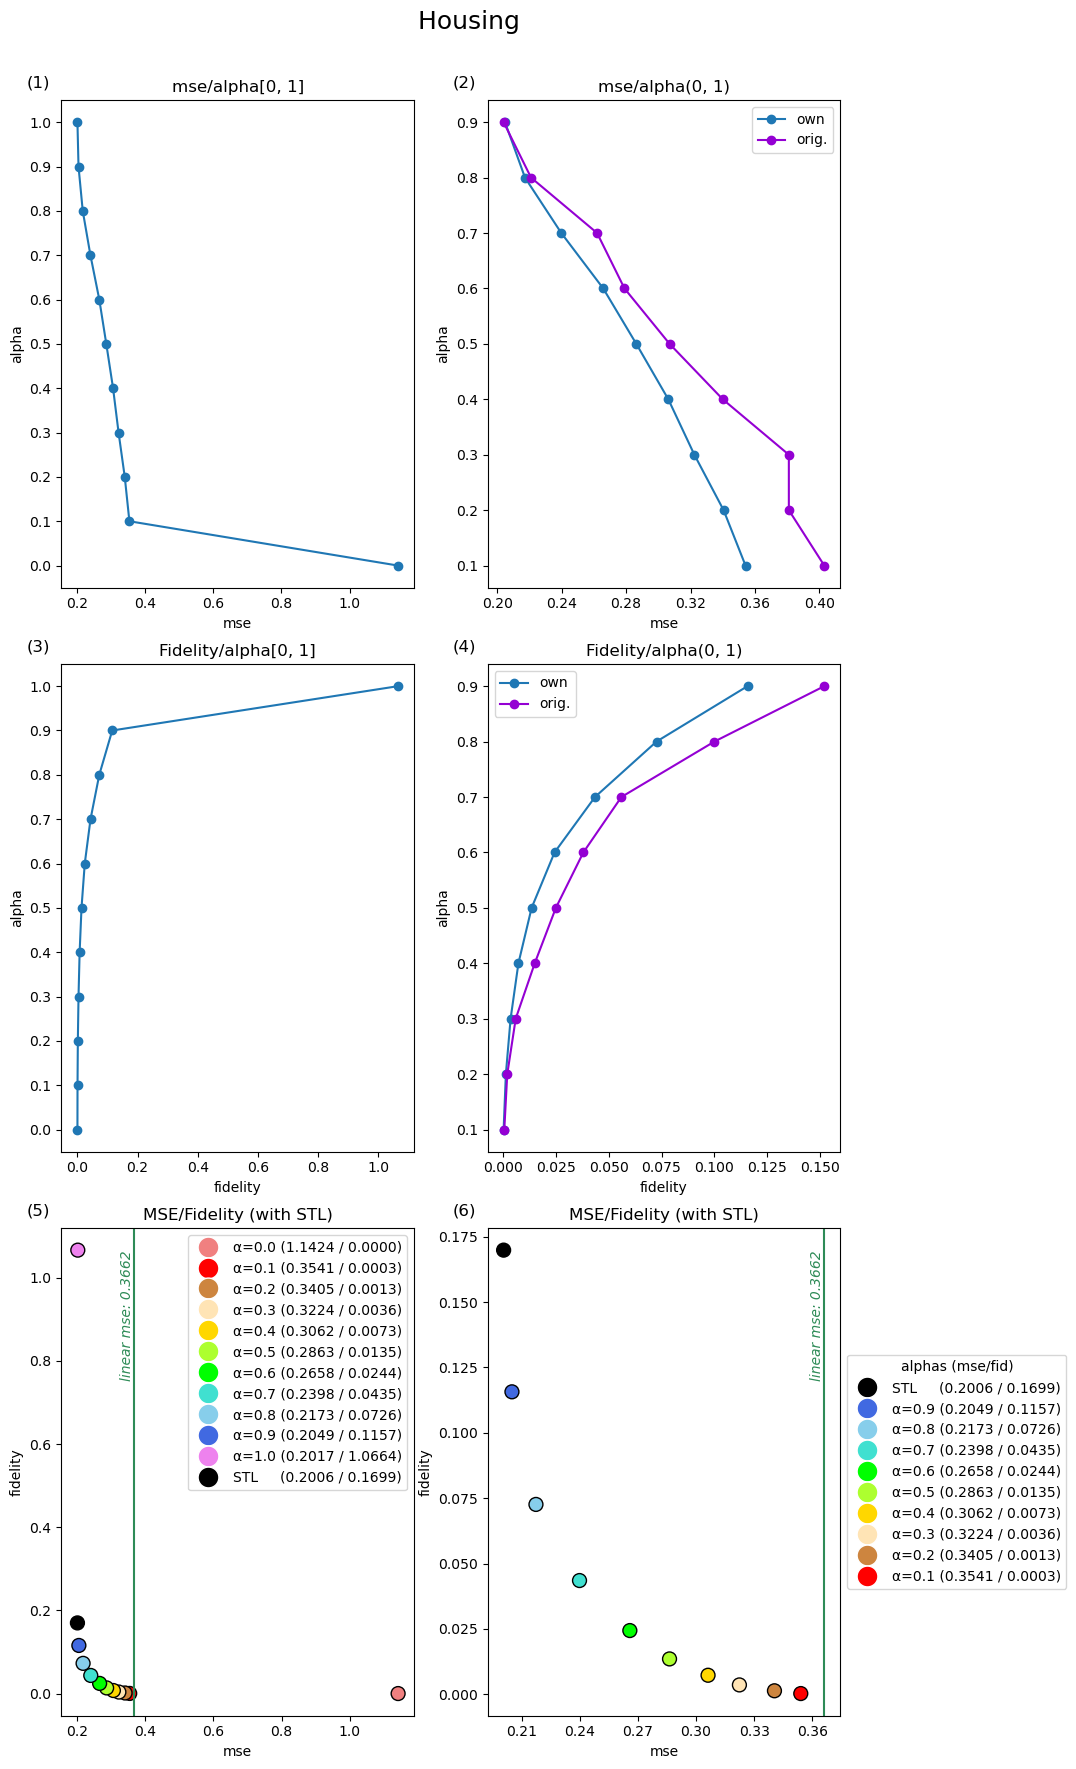

In [454]:
housing_org_results_met = [0.403, 0.381, 0.381, 0.340, 0.307, 0.279, 0.262, 0.221, 0.204]
housing_org_results_gf = [0.0006, 0.002, 0.006, 0.015, 0.025, 0.038, 0.056, 0.100, 0.152]

draw_plots_MTL_vs_STL(
    metrics_label='mse',
    metrics_title='MSE',
    config=housing_cfg,
    org_met=housing_org_results_met,
    org_fid=housing_org_results_gf,
    title='Housing   '
)

### Local Explainability Evaluation

Creating Explainer

In [246]:
housing_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=housing_X_train_np,
    mode='regression',
    feature_names=housing_cfg.features.names,
    verbose=False,
    class_names=['Value'],
    categorical_features=housing_cfg.features.categorical_indices,
    categorical_names=housing_cfg.features.values_names,
    discretize_continuous = False
)
housing_explainer

Global Neighborhood Fidelity for STL MLP

In [250]:
# load model
mlp = MLP_reg(input_size=housing_cfg.input_size, hidden_sizes=MLP_reg.get_hidden_sizes(housing_cfg.best_parameters, housing_cfg)).to(housing_cfg.device)
mlp.load_state_dict(torch.load(housing_cfg.models.mlp_opt + '0' + housing_cfg.models.ext))

# prediction functinon
housing_predict_lime = partial(predict_reg_for_lime, model=mlp, config=housing_cfg)

# neighbors dataset
num_rows = 500
housing_indices = torch.randperm(housing_X_test_np.shape[0])[:num_rows]
housing_neighbors_dataset = housing_X_test_np[housing_indices]
print(housing_neighbors_dataset.shape)


housing_cfg.results.stl_gnf = global_neighborhood_fidelity_reg(
    model=mlp,
    neighbors_dataset=housing_neighbors_dataset,
    explainer=housing_explainer,
    config=housing_cfg,
    predict_func_lime=housing_predict_lime,
    predict_func_model=predict_reg_for_lime,
    n=auto_cfg.num
)
housing_cfg.results.stl_gnf

(500, 8)


[tensor(0.6794, dtype=torch.float64),
 tensor(0.6672, dtype=torch.float64),
 tensor(0.6629, dtype=torch.float64),
 tensor(0.6655, dtype=torch.float64),
 tensor(0.6894, dtype=torch.float64)]

Global Neighborhood Fidelity for MTL

In [251]:
gnf_mtl_reg_n_times(
    neighbors_dataset=housing_neighbors_dataset,
    explainer=housing_explainer,
    model_params=housing_cfg.best_parameters,
    config=housing_cfg,
    n=housing_cfg.num
)

Model for alpha: 0.0
Model: Housing/mtl_alpha_0.0_0.pt, GNF: [tensor(0.0014, dtype=torch.float64)]
Model for alpha: 0.1
Model: Housing/mtl_alpha_0.1_0.pt, GNF: [tensor(0.3023, dtype=torch.float64)]
Model for alpha: 0.2
Model: Housing/mtl_alpha_0.2_0.pt, GNF: [tensor(0.3177, dtype=torch.float64)]
Model for alpha: 0.3
Model: Housing/mtl_alpha_0.3_0.pt, GNF: [tensor(0.3296, dtype=torch.float64)]
Model for alpha: 0.4
Model: Housing/mtl_alpha_0.4_0.pt, GNF: [tensor(0.3434, dtype=torch.float64)]
Model for alpha: 0.5
Model: Housing/mtl_alpha_0.5_0.pt, GNF: [tensor(0.3866, dtype=torch.float64)]
Model for alpha: 0.6
Model: Housing/mtl_alpha_0.6_0.pt, GNF: [tensor(0.4493, dtype=torch.float64)]
Model for alpha: 0.7
Model: Housing/mtl_alpha_0.7_0.pt, GNF: [tensor(0.4466, dtype=torch.float64)]
Model for alpha: 0.8
Model: Housing/mtl_alpha_0.8_0.pt, GNF: [tensor(0.5771, dtype=torch.float64)]
Model for alpha: 0.9
Model: Housing/mtl_alpha_0.9_0.pt, GNF: [tensor(0.5960, dtype=torch.float64)]
Model for 

In [252]:
show_tables_lime(housing_cfg) 

Metric,Dataset,Linear,STL,MTL a= 0.0,MTL a= 0.1,MTL a= 0.2,MTL a= 0.3,MTL a= 0.4,MTL a= 0.5,MTL a= 0.6,MTL a= 0.7,MTL a= 0.8,MTL a= 0.9,MTL a= 1.0
GNF,Housing,-,"0,673","0,001","0,312","0,323","0,324","0,355","0,394","0,442","0,451","0,566","0,592","0,855"
MSE,Housing,"0,366","0,208","0,955","0,354","0,339","0,321","0,304","0,287","0,262","0,236","0,215","0,209","0,204"


## Wine

### Preparation

#### Configuration Settings

In [183]:
wine_cfg = Config(
    folders=Folders(base="Wine/"),
    files=Files(
        data="wine_data.pkl", 
        targets="wine_targets.pkl", 
        study='Wine.plt'
    ),
    training=Training(batch_size=64, num_epochs=750, patience=32),
    tuning=Tuning(num_trials = 50),
)

#### Data Loading and Standardization

In [184]:
# Data Loading
wine_df = pd.read_pickle(wine_cfg.paths.data)

wine_cfg.features.numerical = wine_df.select_dtypes(include='number').columns.values.tolist()
wine_cfg.features.numerical_indices = [wine_df.columns.get_loc(feature) for feature in wine_cfg.features.numerical]
wine_cfg.features.categorical = wine_df.select_dtypes(include='object').columns.values.tolist()
wine_cfg.features.categorical_indices = [wine_df.columns.get_loc(feature) for feature in wine_cfg.features.categorical]
wine_cfg.features.names = wine_df.columns.values.tolist()


# Creating Dictionary 
wine_cfg.features.values_names = {}
for feature, idx in zip(wine_cfg.features.categorical, wine_cfg.features.categorical_indices):
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(wine_df[feature])
    wine_df[feature] = le.transform(wine_df[feature])
    wine_cfg.features.values_names[idx] = le.classes_
    
# Data Splitting
wine_X_train, wine_X_test, wine_y_train, wine_y_test = train_test_split(
    wine_df,
    np.array(pd.read_pickle(wine_cfg.paths.targets)), 
    test_size=0.2, 
    random_state=42
)

wine_X_eval, wine_X_test, wine_y_eval, wine_y_test = train_test_split(
    wine_X_test, 
    wine_y_test, 
    test_size=0.5, 
    random_state=42
)

# Data Scaling
wine_scaler = StandardScaler()
wine_X_train[wine_cfg.features.numerical] = wine_scaler.fit_transform(wine_X_train[wine_cfg.features.numerical]).astype(float)
wine_X_train[wine_cfg.features.categorical] = wine_X_train[wine_cfg.features.categorical].astype(float)

wine_X_eval[wine_cfg.features.numerical] = wine_scaler.transform(wine_X_eval[wine_cfg.features.numerical]).astype(float)
wine_X_eval[wine_cfg.features.categorical] = wine_X_eval[wine_cfg.features.categorical].astype(float)

wine_X_test[wine_cfg.features.numerical] = wine_scaler.transform(wine_X_test[wine_cfg.features.numerical]).astype(float)
wine_X_test[wine_cfg.features.categorical] = wine_X_test[wine_cfg.features.categorical].astype(float)


wine_scaler_y = StandardScaler()
wine_y_train = wine_scaler_y.fit_transform(wine_y_train)
wine_y_eval = wine_scaler_y.transform(wine_y_eval)
wine_y_test = wine_scaler_y.transform(wine_y_test)

# Data Encoding with reindexing to maintain uniform number of columns
wine_cfg.features.dummy = pd.get_dummies(wine_df.astype(float), columns=wine_cfg.features.categorical, dtype=float).columns 

wine_X_train_encoded = pd.get_dummies(wine_X_train, columns=wine_cfg.features.categorical, dtype=float)
wine_X_train_encoded = wine_X_train_encoded.reindex(columns=wine_cfg.features.dummy, fill_value=0.0).values

wine_X_eval_encoded = pd.get_dummies(wine_X_eval, columns=wine_cfg.features.categorical, dtype=float)
wine_X_eval_encoded = wine_X_eval_encoded.reindex(columns=wine_cfg.features.dummy, fill_value=0.0).values

wine_X_test_encoded = pd.get_dummies(wine_X_test, columns=wine_cfg.features.categorical, dtype=float)
wine_X_test_encoded = wine_X_test_encoded.reindex(columns=wine_cfg.features.dummy, fill_value=0.0).values

# Data Conversion 
wine_X_train_tensor = torch.tensor(wine_X_train_encoded, dtype=torch.float32)
wine_X_eval_tensor = torch.tensor(wine_X_eval_encoded, dtype=torch.float32)
wine_X_test_tensor = torch.tensor(wine_X_test_encoded, dtype=torch.float32)

wine_y_train_tensor = torch.tensor(wine_y_train, dtype=torch.float32)
wine_y_eval_tensor = torch.tensor(wine_y_eval, dtype=torch.float32)
wine_y_test_tensor = torch.tensor(wine_y_test, dtype=torch.float32)

wine_X_train_np = wine_X_train.values
wine_X_eval_np = wine_X_eval.values
wine_X_test_np = wine_X_test.values

# Updating Configuration 
wine_cfg.input_size = wine_X_train_tensor.shape[1]
wine_cfg.tuning.min_neurons = wine_cfg.input_size // 4 - 1
wine_cfg.tuning.max_neurons = wine_cfg.input_size * 4 + 1

### Finding Best MLP model

#### Optimization Function

In [185]:
def train_and_optimize_wine(trial, config: Config):
    print(f"Trial: {trial}")
    num_layers = trial.suggest_int(config.tuning.name_layers, config.tuning.min_layers, config.tuning.max_layers)
    hidden_sizes = [trial.suggest_int(f'{config.tuning.name_neurons}{i}', config.tuning.min_neurons, config.tuning.max_neurons) for i in range(num_layers)]

    model = MLP_reg(config.input_size, hidden_sizes, 1)

    mse = train_eval(
        data_train=wine_X_train_tensor,
        target_train=wine_y_train_tensor,
        data_eval=wine_X_eval_tensor,
        target_eval=wine_y_eval_tensor,
        model=model,
        criterion_train=LogHCos(),
        criterion_eval=MSELoss(),
        eval_func=eval_reg,
        direction='min',
        config=config
    )
    return mse

#### Model Optimization

In [186]:
def study_wine(config: Config):
    objective = partial(train_and_optimize_wine, config=config)
    study = optuna.create_study(
        study_name=config.files.study, 
        sampler=config.tuning.sampler(), 
        direction='minimize', 
    )
    study.optimize(objective, n_trials=config.tuning.num_trials, show_progress_bar=True)
    joblib.dump(study, config.paths.study)
    return study

wine_study = try_load_study(study_wine, wine_cfg)

In [187]:
wine_study.trials_dataframe().sort_values("value", ascending=True).drop(['datetime_start', 'datetime_complete'], axis=1).head(5)

,number,value,duration,params_num_layers,params_num_neurons0,params_num_neurons1,params_num_neurons2,params_num_neurons3,params_num_neurons4,state
33,33,0.500907,0 days 00:00:07.761408,2,42,24.0,NaN,NaN,NaN,COMPLETE
43,43,0.510618,0 days 00:00:06.457184,4,36,44.0,5.0,24.0,NaN,COMPLETE
7,7,0.515078,0 days 00:00:15.047941,2,38,3.0,NaN,NaN,NaN,COMPLETE
19,19,0.520246,0 days 00:00:06.776386,2,30,12.0,NaN,NaN,NaN,COMPLETE
41,41,0.520530,0 days 00:00:04.329740,4,39,36.0,17.0,26.0,NaN,COMPLETE


In [188]:
# study.best_params
print(wine_study.trials[33].value)

wine_cfg.best_parameters = wine_study.trials[33].params
wine_cfg.best_parameters

0.5009070038795471


{'num_layers': 2, 'num_neurons0': 42, 'num_neurons1': 24}

### Training and Testing MLP

In [189]:
train_and_test_mlp_reg(
    X_train=wine_X_train_tensor, 
    y_train=wine_y_train_tensor,
    X_eval=wine_X_eval_tensor, 
    y_eval=wine_y_eval_tensor, 
    X_test=wine_X_test_tensor, 
    y_test=wine_y_test_tensor, 
    config=wine_cfg
)
print(np.mean(list(wine_cfg.results.stl_mlp.values())))
wine_cfg.results.stl_mlp

Model Wine/mlp_opt_0.pt loaded successfully
Model Wine/mlp_opt_1.pt loaded successfully
Model Wine/mlp_opt_2.pt loaded successfully
Model Wine/mlp_opt_3.pt loaded successfully
Model Wine/mlp_opt_4.pt loaded successfully
0.6265387058258056


{0: 0.6444972157478333,
 1: 0.6329270005226135,
 2: 0.6132732033729553,
 3: 0.6196596622467041,
 4: 0.6223364472389221}

### Training and Testing Linear Model

In [190]:
train_and_test_lin_reg(
    X_train=wine_X_train_tensor, 
    y_train=wine_y_train_tensor,
    X_eval=wine_X_eval_tensor, 
    y_eval=wine_y_eval_tensor, 
    X_test=wine_X_test_tensor, 
    y_test=wine_y_test_tensor, 
    config=wine_cfg
)
print(np.mean(list(wine_cfg.results.reg.values())))
wine_cfg.results.reg

Model Wine/reg_0.pt loaded successfully
Model Wine/reg_1.pt loaded successfully
Model Wine/reg_2.pt loaded successfully
Model Wine/reg_3.pt loaded successfully
Model Wine/reg_4.pt loaded successfully
0.6557277083396912


{0: 0.6487641930580139,
 1: 0.6670450568199158,
 2: 0.656655490398407,
 3: 0.6469407081604004,
 4: 0.6592330932617188}

### Training and Testing STL Surogate Model

Train Linear Regression to explain wine_mlp_stl model

In [191]:
train_and_test_stl_lin_reg(
    X_train=wine_X_train_tensor, 
    X_eval=wine_X_eval_tensor, 
    X_test=wine_X_test_tensor, 
    config=wine_cfg
)
print(np.mean(list(wine_cfg.results.stl_reg.values())))
wine_cfg.results.stl_reg

Model Wine/stl_reg_0.pt loaded successfully
Model Wine/stl_reg_1.pt loaded successfully
Model Wine/stl_reg_2.pt loaded successfully
Model Wine/stl_reg_3.pt loaded successfully
Model Wine/stl_reg_4.pt loaded successfully
0.06951482072472573


{0: 0.08603735268115997,
 1: 0.07350988686084747,
 2: 0.06872521340847015,
 3: 0.05231377109885216,
 4: 0.06698787957429886}

### Training and Testing Models in MTL Approach 

MLP + LinReg, alpha in the range of 0 to 1 with a step of 0.1.

In [192]:
train_and_test_mtl_reg(
    X_train=wine_X_train_tensor,
    y_train=wine_y_train_tensor,
    X_eval=wine_X_eval_tensor, 
    y_eval=wine_y_eval_tensor, 
    X_test=wine_X_test_tensor, 
    y_test=wine_y_test_tensor, 
    config=wine_cfg
)
wine_cfg.results.mtl

Model for alpha: 0.0
Model Wine/mtl_alpha_0.0_0.pt loaded successfully
Model: Wine/mtl_alpha_0.0_0.pt, MSE: 1.378847360610962, Fidelity: 1.7606520486879162e-05
Model for alpha: 0.1
Model Wine/mtl_alpha_0.1_0.pt loaded successfully
Model: Wine/mtl_alpha_0.1_0.pt, MSE: 0.6471073031425476, Fidelity: 0.0007901379722170532
Model for alpha: 0.2
Model Wine/mtl_alpha_0.2_0.pt loaded successfully
Model: Wine/mtl_alpha_0.2_0.pt, MSE: 0.6388683319091797, Fidelity: 0.002186032710596919
Model for alpha: 0.3
Model Wine/mtl_alpha_0.3_0.pt loaded successfully
Model: Wine/mtl_alpha_0.3_0.pt, MSE: 0.6264545321464539, Fidelity: 0.0062066600657999516
Model for alpha: 0.4
Model Wine/mtl_alpha_0.4_0.pt loaded successfully
Model: Wine/mtl_alpha_0.4_0.pt, MSE: 0.62045818567276, Fidelity: 0.007078320719301701
Model for alpha: 0.5
Model Wine/mtl_alpha_0.5_0.pt loaded successfully
Model: Wine/mtl_alpha_0.5_0.pt, MSE: 0.6108199954032898, Fidelity: 0.017435012385249138
Model for alpha: 0.6
Model Wine/mtl_alpha_0.6

{0: {'0.0': Result(metrics=1.378847360610962, fid=1.7606520486879162e-05),
  '0.1': Result(metrics=0.6471073031425476, fid=0.0007901379722170532),
  '0.2': Result(metrics=0.6388683319091797, fid=0.002186032710596919),
  '0.3': Result(metrics=0.6264545321464539, fid=0.0062066600657999516),
  '0.4': Result(metrics=0.62045818567276, fid=0.007078320719301701),
  '0.5': Result(metrics=0.6108199954032898, fid=0.017435012385249138),
  '0.6': Result(metrics=0.6176782250404358, fid=0.028662946075201035),
  '0.7': Result(metrics=0.6077611446380615, fid=0.03796644136309624),
  '0.8': Result(metrics=0.6152499318122864, fid=0.05672808364033699),
  '0.9': Result(metrics=0.6026071310043335, fid=0.06694678962230682),
  '1.0': Result(metrics=0.6000400185585022, fid=0.8952798247337341)},
 1: {'0.0': Result(metrics=1.3306323289871216, fid=2.4134038540069014e-05),
  '0.1': Result(metrics=0.6363160610198975, fid=0.001116522355005145),
  '0.2': Result(metrics=0.6273491978645325, fid=0.0013772008242085576),


### Comparison of STL with MTL

In [253]:
wine_cfg.metrics_label = 'MSE'
show_tables(wine_cfg) 

Metrics,Dataset,Linear,Non-linear (MLP)
MSE,Wine,"0,6557","0,6265"


Metrics,Dataset,Linear,STL,MTL a= 0.0,MTL a= 0.1,MTL a= 0.2,MTL a= 0.3,MTL a= 0.4,MTL a= 0.5,MTL a= 0.6,MTL a= 0.7,MTL a= 0.8,MTL a= 0.9,MTL a= 1.0
MSE,Wine,"0,6557","0,6265","1,2660","0,6521","0,6410","0,6402","0,6255","0,6279","0,6124","0,6211","0,6244","0,6128","0,6313"
Global Fidelity,Wine,-,"0,0695","0,0000","0,0008","0,0018","0,0045","0,0083","0,0166","0,0241","0,0323","0,0548","0,0596","1,1165"


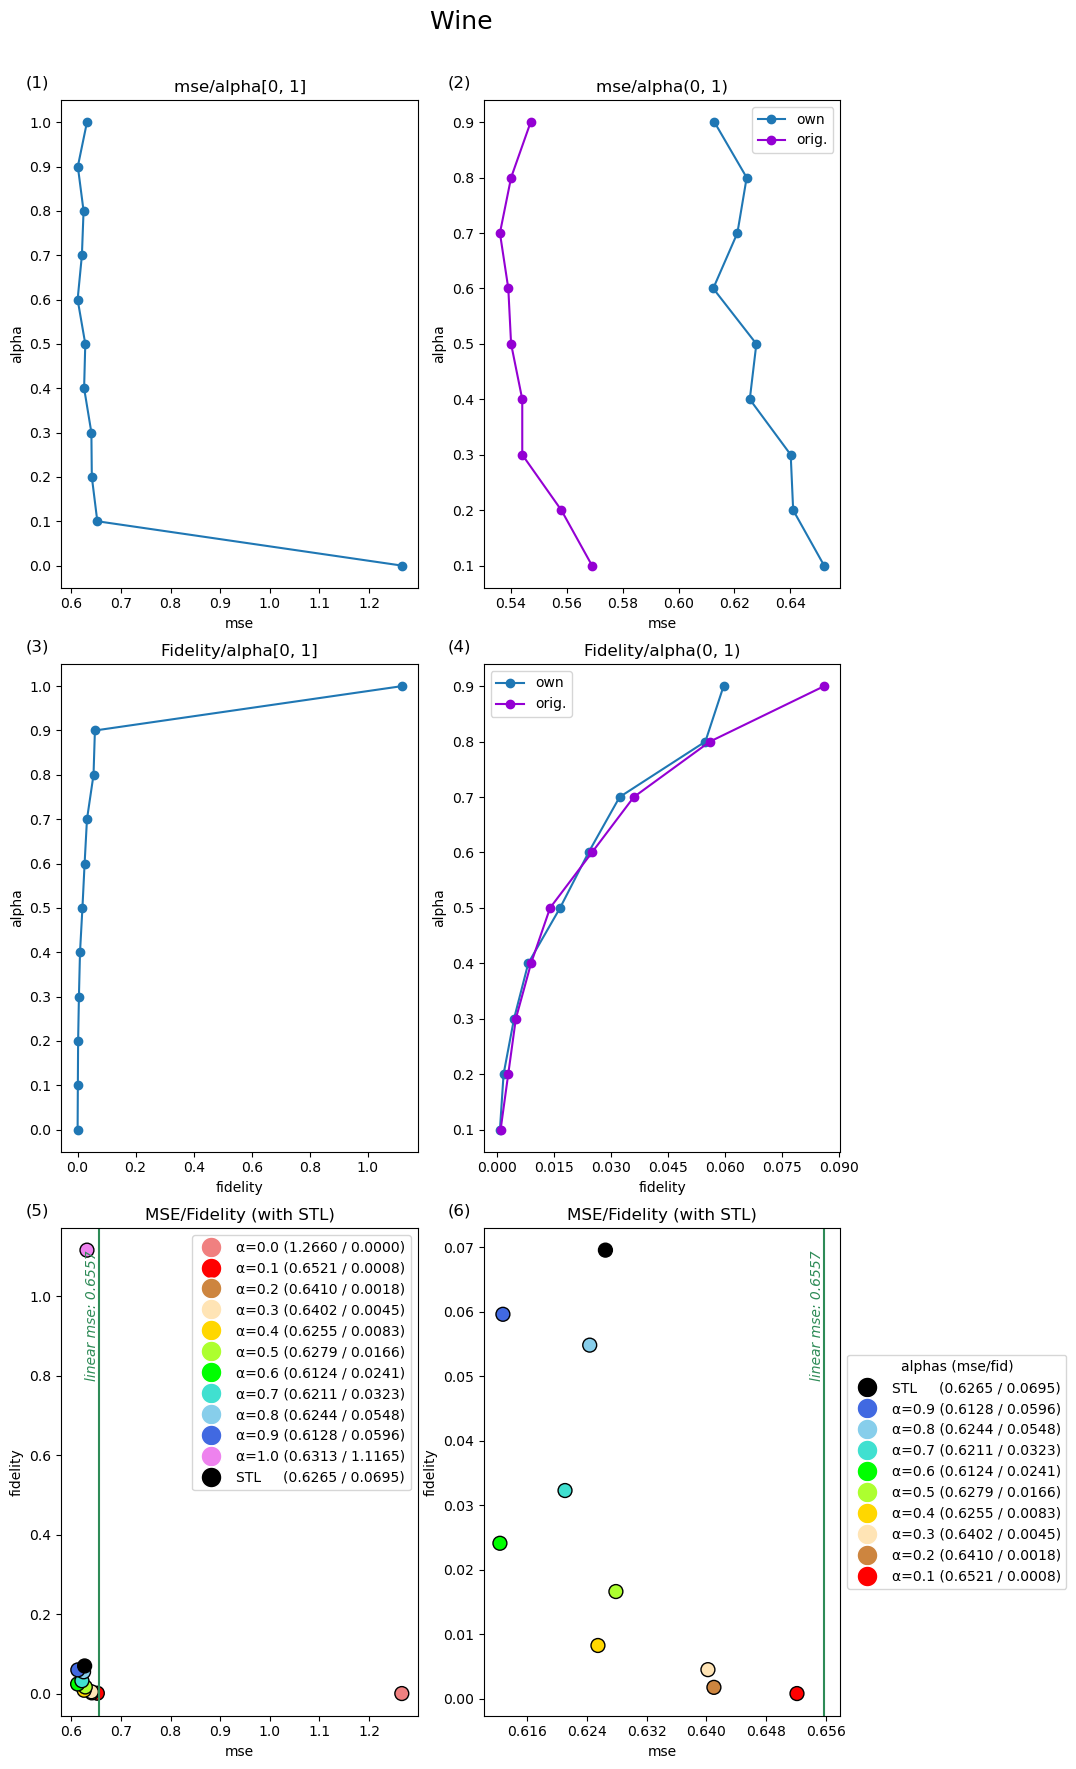

In [455]:
wine_org_results_met = [0.569, 0.558, 0.544, 0.544, 0.540, 0.539, 0.536, 0.540, 0.547]
wine_org_results_gf = [0.001, 0.003, 0.005, 0.009, 0.014, 0.025, 0.036, 0.056, 0.086]

draw_plots_MTL_vs_STL(
    metrics_label='mse',
    metrics_title='MSE',
    config=wine_cfg,
    org_met=wine_org_results_met,
    org_fid=wine_org_results_gf,
    title='Wine     '
)

### Local Explainability Evaluation

Creating Explainer

In [255]:
wine_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=wine_X_train_np,
    mode='regression',
    feature_names=wine_cfg.features.names,
    verbose=False,
    class_names=['quality'],
    categorical_features=wine_cfg.features.categorical_indices,
    categorical_names=wine_cfg.features.values_names,
    discretize_continuous=False
)
wine_explainer

Global Neighborhood Fidelity for STL MLP

In [256]:
# load model
mlp = MLP_reg(input_size=wine_cfg.input_size, hidden_sizes=MLP_reg.get_hidden_sizes(wine_cfg.best_parameters, wine_cfg)).to(wine_cfg.device)
mlp.load_state_dict(torch.load(wine_cfg.models.mlp_opt + '0' + wine_cfg.models.ext))

# prediction function
wine_predict_lime = partial(predict_reg_for_lime, model=mlp, config=wine_cfg)

# neighbors dataset
wine_neighbors_dataset = wine_X_test_np
print(wine_neighbors_dataset.shape)


wine_cfg.results.stl_gnf = global_neighborhood_fidelity_reg(
    model=mlp,
    neighbors_dataset=wine_neighbors_dataset,
    explainer=wine_explainer,
    config=wine_cfg,
    predict_func_lime=wine_predict_lime,
    predict_func_model=predict_reg_for_lime,
    n=wine_cfg.num
)
wine_cfg.results.stl_gnf

(136, 11)


[tensor(0.1587, dtype=torch.float64),
 tensor(0.1616, dtype=torch.float64),
 tensor(0.1685, dtype=torch.float64),
 tensor(0.1636, dtype=torch.float64),
 tensor(0.1577, dtype=torch.float64)]

Global Neighborhood Fidelity for MTL

In [257]:
gnf_mtl_reg_n_times(
    neighbors_dataset=wine_neighbors_dataset,
    explainer=wine_explainer,
    model_params=wine_cfg.best_parameters,
    config=wine_cfg,
    n=wine_cfg.num
)

Model for alpha: 0.0
Model: Wine/mtl_alpha_0.0_0.pt, GNF: [tensor(0.0075, dtype=torch.float64)]
Model for alpha: 0.1
Model: Wine/mtl_alpha_0.1_0.pt, GNF: [tensor(0.0486, dtype=torch.float64)]
Model for alpha: 0.2
Model: Wine/mtl_alpha_0.2_0.pt, GNF: [tensor(0.0506, dtype=torch.float64)]
Model for alpha: 0.3
Model: Wine/mtl_alpha_0.3_0.pt, GNF: [tensor(0.0546, dtype=torch.float64)]
Model for alpha: 0.4
Model: Wine/mtl_alpha_0.4_0.pt, GNF: [tensor(0.0559, dtype=torch.float64)]
Model for alpha: 0.5
Model: Wine/mtl_alpha_0.5_0.pt, GNF: [tensor(0.0580, dtype=torch.float64)]
Model for alpha: 0.6
Model: Wine/mtl_alpha_0.6_0.pt, GNF: [tensor(0.0995, dtype=torch.float64)]
Model for alpha: 0.7
Model: Wine/mtl_alpha_0.7_0.pt, GNF: [tensor(0.0934, dtype=torch.float64)]
Model for alpha: 0.8
Model: Wine/mtl_alpha_0.8_0.pt, GNF: [tensor(0.1193, dtype=torch.float64)]
Model for alpha: 0.9
Model: Wine/mtl_alpha_0.9_0.pt, GNF: [tensor(0.1223, dtype=torch.float64)]
Model for alpha: 1.0
Model: Wine/mtl_alp

In [258]:
show_tables_lime(wine_cfg) 

Metric,Dataset,Linear,STL,MTL a= 0.0,MTL a= 0.1,MTL a= 0.2,MTL a= 0.3,MTL a= 0.4,MTL a= 0.5,MTL a= 0.6,MTL a= 0.7,MTL a= 0.8,MTL a= 0.9,MTL a= 1.0
GNF,Wine,-,"0,162","0,008","0,050","0,050","0,054","0,056","0,060","0,100","0,093","0,121","0,126","0,096"
MSE,Wine,"0,649","0,644","1,379","0,647","0,639","0,626","0,620","0,611","0,618","0,608","0,615","0,603","0,600"


## Adult

### Preparation

#### Configuration Settings

In [194]:
adult_cfg = Config(
    folders=Folders(base="Adult/"),
    files=Files(
        data="adult_data.pkl", 
        targets="adult_targets.pkl", 
        study='Adult.plt'
    ),
    training=Training(batch_size=64),
    tuning=Tuning(num_trials = 25),
)

#### Data Loading and Standardization

In [195]:
# Data Loading
adult_df = pd.read_pickle(adult_cfg.paths.data)

adult_cfg.features.numerical = adult_df.select_dtypes(include='number').columns.values.tolist()
adult_cfg.features.numerical_indices = [adult_df.columns.get_loc(feature) for feature in adult_cfg.features.numerical]
adult_cfg.features.categorical = adult_df.select_dtypes(include='object').columns.values.tolist()
adult_cfg.features.categorical_indices = [adult_df.columns.get_loc(feature) for feature in adult_cfg.features.categorical]
adult_cfg.features.names = adult_df.columns.values.tolist()


# Creating Dictionary 
adult_cfg.features.values_names = {}
for feature, idx in zip(adult_cfg.features.categorical, adult_cfg.features.categorical_indices):
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(adult_df[feature])
    adult_df[feature] = le.transform(adult_df[feature])
    adult_cfg.features.values_names[idx] = le.classes_
    
# Data Splitting
adult_X_train, adult_X_test, adult_y_train, adult_y_test = train_test_split(
    adult_df,
    np.array(pd.read_pickle(adult_cfg.paths.targets)), 
    test_size=0.2, 
    random_state=42
)

adult_X_eval, adult_X_test, adult_y_eval, adult_y_test = train_test_split(
    adult_X_test, 
    adult_y_test, 
    test_size=0.5, 
    random_state=42
)

# Data Scaling
adult_scaler = StandardScaler()
adult_X_train[adult_cfg.features.numerical] = adult_scaler.fit_transform(adult_X_train[adult_cfg.features.numerical]).astype(float)
adult_X_train[adult_cfg.features.categorical] = adult_X_train[adult_cfg.features.categorical].astype(float)

adult_X_eval[adult_cfg.features.numerical] = adult_scaler.transform(adult_X_eval[adult_cfg.features.numerical]).astype(float)
adult_X_eval[adult_cfg.features.categorical] = adult_X_eval[adult_cfg.features.categorical].astype(float)

adult_X_test[adult_cfg.features.numerical] = adult_scaler.transform(adult_X_test[adult_cfg.features.numerical]).astype(float)
adult_X_test[adult_cfg.features.categorical] = adult_X_test[adult_cfg.features.categorical].astype(float)

# Data Encoding with reindexing to maintain uniform number of columns
adult_cfg.features.dummy = pd.get_dummies(adult_df.astype(float), columns=adult_cfg.features.categorical, dtype=float).columns 

adult_X_train_encoded = pd.get_dummies(adult_X_train, columns=adult_cfg.features.categorical, dtype=float)
adult_X_train_encoded = adult_X_train_encoded.reindex(columns=adult_cfg.features.dummy, fill_value=0.0).values

adult_X_eval_encoded = pd.get_dummies(adult_X_eval, columns=adult_cfg.features.categorical, dtype=float)
adult_X_eval_encoded = adult_X_eval_encoded.reindex(columns=adult_cfg.features.dummy, fill_value=0.0).values

adult_X_test_encoded = pd.get_dummies(adult_X_test, columns=adult_cfg.features.categorical, dtype=float)
adult_X_test_encoded = adult_X_test_encoded.reindex(columns=adult_cfg.features.dummy, fill_value=0.0).values

# Data Conversion 
adult_X_train_tensor = torch.tensor(adult_X_train_encoded, dtype=torch.float32)
adult_X_eval_tensor = torch.tensor(adult_X_eval_encoded, dtype=torch.float32)
adult_X_test_tensor = torch.tensor(adult_X_test_encoded, dtype=torch.float32)

adult_y_train_tensor = torch.tensor(adult_y_train, dtype=torch.float32)
adult_y_eval_tensor = torch.tensor(adult_y_eval, dtype=torch.float32)
adult_y_test_tensor = torch.tensor(adult_y_test, dtype=torch.float32)

adult_X_train_np = adult_X_train.values
adult_X_eval_np = adult_X_eval.values
adult_X_test_np = adult_X_test.values

# Updating Configuration 
adult_cfg.input_size = adult_X_train_tensor.shape[1]
adult_cfg.tuning.min_neurons = adult_cfg.input_size // 4 - 1
adult_cfg.tuning.max_neurons = adult_cfg.input_size * 4 + 1

### Finding Best MLP model

#### Optimization Function

In [196]:
def train_and_optimize_adult(trial, config: Config):
    num_layers = trial.suggest_int(config.tuning.name_layers, config.tuning.min_layers, config.tuning.max_layers)
    hidden_sizes = [trial.suggest_int(f'{config.tuning.name_neurons}{i}', config.tuning.min_neurons, config.tuning.max_neurons) for i in range(num_layers)]

    model = MLP_cls(config.input_size, hidden_sizes, 1)

    acc = train_eval(
        data_train=adult_X_train_tensor,
        target_train=adult_y_train_tensor,
        data_eval=adult_X_eval_tensor,
        target_eval=adult_y_eval_tensor,
        model=model,
        criterion_train=BCELoss(),
        criterion_eval=AccuracyScore(),
        eval_func=eval_cls,
        direction='max',
        config=config
    )
    return acc

#### Model Optimization

In [197]:
def study_adult(config: Config):
    objective = partial(train_and_optimize_adult, config=config)
    study = optuna.create_study(
        study_name=config.files.study, 
        sampler=config.tuning.sampler(), 
        direction='maximize', 
    )
    study.optimize(objective, n_trials=config.tuning.num_trials, show_progress_bar=True)
    joblib.dump(study, config.paths.study)
    return study

adult_study = try_load_study(study_adult, adult_cfg)

In [198]:
adult_study.trials_dataframe().sort_values("value", ascending=False).drop(['datetime_start', 'datetime_complete'], axis=1).head(5)

,number,value,duration,params_num_layers,params_num_neurons0,params_num_neurons1,params_num_neurons2,params_num_neurons3,params_num_neurons4,state
9,9,0.857269,0 days 00:00:24.640187,2,132,273.0,NaN,NaN,NaN,COMPLETE
17,17,0.855942,0 days 00:00:34.097176,2,35,406.0,NaN,NaN,NaN,COMPLETE
14,14,0.855278,0 days 00:00:32.678021,2,94,339.0,NaN,NaN,NaN,COMPLETE
8,8,0.855056,0 days 00:00:38.689916,1,311,NaN,NaN,NaN,NaN,COMPLETE
24,24,0.854171,0 days 00:00:25.166934,3,169,310.0,384.0,NaN,NaN,COMPLETE


In [199]:
# study.best_params
print(adult_study.trials[9].value)

adult_cfg.best_parameters = adult_study.trials[9].params
adult_cfg.best_parameters

0.857269287109375


{'num_layers': 2, 'num_neurons0': 132, 'num_neurons1': 273}

### Training and Testing MLP

In [200]:
train_and_test_mlp_cls(
    X_train=adult_X_train_tensor, 
    y_train=adult_y_train_tensor,
    X_eval=adult_X_eval_tensor, 
    y_eval=adult_y_eval_tensor, 
    X_test=adult_X_test_tensor, 
    y_test=adult_y_test_tensor, 
    config=adult_cfg
)
print(np.mean(list(adult_cfg.results.stl_mlp.values())))
adult_cfg.results.stl_mlp

Model Adult/mlp_opt_0.pt loaded successfully
Model Adult/mlp_opt_1.pt loaded successfully
Model Adult/mlp_opt_2.pt loaded successfully
Model Adult/mlp_opt_3.pt loaded successfully
Model Adult/mlp_opt_4.pt loaded successfully
0.8519468903541565


{0: 0.8513274192810059,
 1: 0.8504424691200256,
 2: 0.8480088710784912,
 3: 0.8559734225273132,
 4: 0.8539822697639465}

### Training and Testing Linear Model

In [201]:
train_and_test_lin_cls(
    X_train=adult_X_train_tensor, 
    y_train=adult_y_train_tensor,
    X_eval=adult_X_eval_tensor, 
    y_eval=adult_y_eval_tensor, 
    X_test=adult_X_test_tensor, 
    y_test=adult_y_test_tensor, 
    config=adult_cfg
)
print(np.mean(list(adult_cfg.results.reg.values())))
adult_cfg.results.reg

Model Adult/reg_0.pt loaded successfully
Model Adult/reg_1.pt loaded successfully
Model Adult/reg_2.pt loaded successfully
Model Adult/reg_3.pt loaded successfully
Model Adult/reg_4.pt loaded successfully
0.8504867315292358


{0: 0.8506637215614319,
 1: 0.8506637215614319,
 2: 0.8504424691200256,
 3: 0.8500000238418579,
 4: 0.8506637215614319}

### Training and Testing STL Surogate Model

Train Logistic Regression to explain adult_mlp_stl model

In [202]:
train_and_test_stl_lin_cls(
    X_train=adult_X_train_tensor, 
    X_eval=adult_X_eval_tensor, 
    X_test=adult_X_test_tensor, 
    config=adult_cfg
)
print(np.mean(list(adult_cfg.results.stl_reg.values())))
adult_cfg.results.stl_reg

Model Adult/stl_reg_0.pt loaded successfully
Model Adult/stl_reg_1.pt loaded successfully
Model Adult/stl_reg_2.pt loaded successfully
Model Adult/stl_reg_3.pt loaded successfully
Model Adult/stl_reg_4.pt loaded successfully
0.04287610650062561


{0: 0.04668141528964043,
 1: 0.0358407087624073,
 2: 0.05309734493494034,
 3: 0.04402654990553856,
 4: 0.034734513610601425}

### Training and Testing Models in MTL Approach 

MLP + LinReg, alpha in the range of 0 to 1 with a step of 0.1.

In [203]:
train_and_test_mtl_cls(
    X_train=adult_X_train_tensor,
    y_train=adult_y_train_tensor,
    X_eval=adult_X_eval_tensor, 
    y_eval=adult_y_eval_tensor, 
    X_test=adult_X_test_tensor, 
    y_test=adult_y_test_tensor, 
    config=adult_cfg
)
adult_cfg.results.mtl

Model for alpha: 0.0
Model Adult/mtl_alpha_0.0_0.pt loaded successfully
Result on test dataset: Adult/mtl_alpha_0.0_0.pt, Accuracy: 0.7484513521194458, Fidelity: 0.00022123893722891808
Model for alpha: 0.1
Model Adult/mtl_alpha_0.1_0.pt loaded successfully
Result on test dataset: Adult/mtl_alpha_0.1_0.pt, Accuracy: 0.8497787714004517, Fidelity: 0.014823008328676224
Model for alpha: 0.2
Model Adult/mtl_alpha_0.2_0.pt loaded successfully
Result on test dataset: Adult/mtl_alpha_0.2_0.pt, Accuracy: 0.8526548743247986, Fidelity: 0.01902654767036438
Model for alpha: 0.3
Model Adult/mtl_alpha_0.3_0.pt loaded successfully
Result on test dataset: Adult/mtl_alpha_0.3_0.pt, Accuracy: 0.8530973196029663, Fidelity: 0.03362831845879555
Model for alpha: 0.4
Model Adult/mtl_alpha_0.4_0.pt loaded successfully
Result on test dataset: Adult/mtl_alpha_0.4_0.pt, Accuracy: 0.8533185720443726, Fidelity: 0.03694690391421318
Model for alpha: 0.5
Model Adult/mtl_alpha_0.5_0.pt loaded successfully
Result on test

{0: {'0.0': Result(metrics=0.7484513521194458, fid=0.00022123893722891808),
  '0.1': Result(metrics=0.8497787714004517, fid=0.014823008328676224),
  '0.2': Result(metrics=0.8526548743247986, fid=0.01902654767036438),
  '0.3': Result(metrics=0.8530973196029663, fid=0.03362831845879555),
  '0.4': Result(metrics=0.8533185720443726, fid=0.03694690391421318),
  '0.5': Result(metrics=0.8515486717224121, fid=0.0358407087624073),
  '0.6': Result(metrics=0.8488938212394714, fid=0.04247787594795227),
  '0.7': Result(metrics=0.855088472366333, fid=0.04800884798169136),
  '0.8': Result(metrics=0.8522123694419861, fid=0.05287610739469528),
  '0.9': Result(metrics=0.8524336218833923, fid=0.06305309385061264),
  '1.0': Result(metrics=0.8559734225273132, fid=0.5119469165802002)},
 1: {'0.0': Result(metrics=0.7464601993560791, fid=0.0),
  '0.1': Result(metrics=0.8539822697639465, fid=0.014823008328676224),
  '0.2': Result(metrics=0.8519911766052246, fid=0.024115044623613358),
  '0.3': Result(metrics=0.

### Comparison of STL with MTL

In [205]:
adult_cfg.metrics_label = "ACC"
show_tables(adult_cfg) 

Metric,Dataset,Linear,Non-linear (MLP)
ACC,Adult,"0,8505","0,8519"


Metric,Dataset,Linear,STL,MTL a= 0.0,MTL a= 0.1,MTL a= 0.2,MTL a= 0.3,MTL a= 0.4,MTL a= 0.5,MTL a= 0.6,MTL a= 0.7,MTL a= 0.8,MTL a= 0.9,MTL a= 1.0
ACC,Adult,"0,8505","0,8519","0,7478","0,8518","0,8527","0,8521","0,8520","0,8537","0,8529","0,8538","0,8531","0,8528","0,8538"
Global Fidelity,Adult,-,"0,0429","0,0001","0,0153","0,0235","0,0326","0,0356","0,0379","0,0427","0,0457","0,0499","0,0543","0,4212"


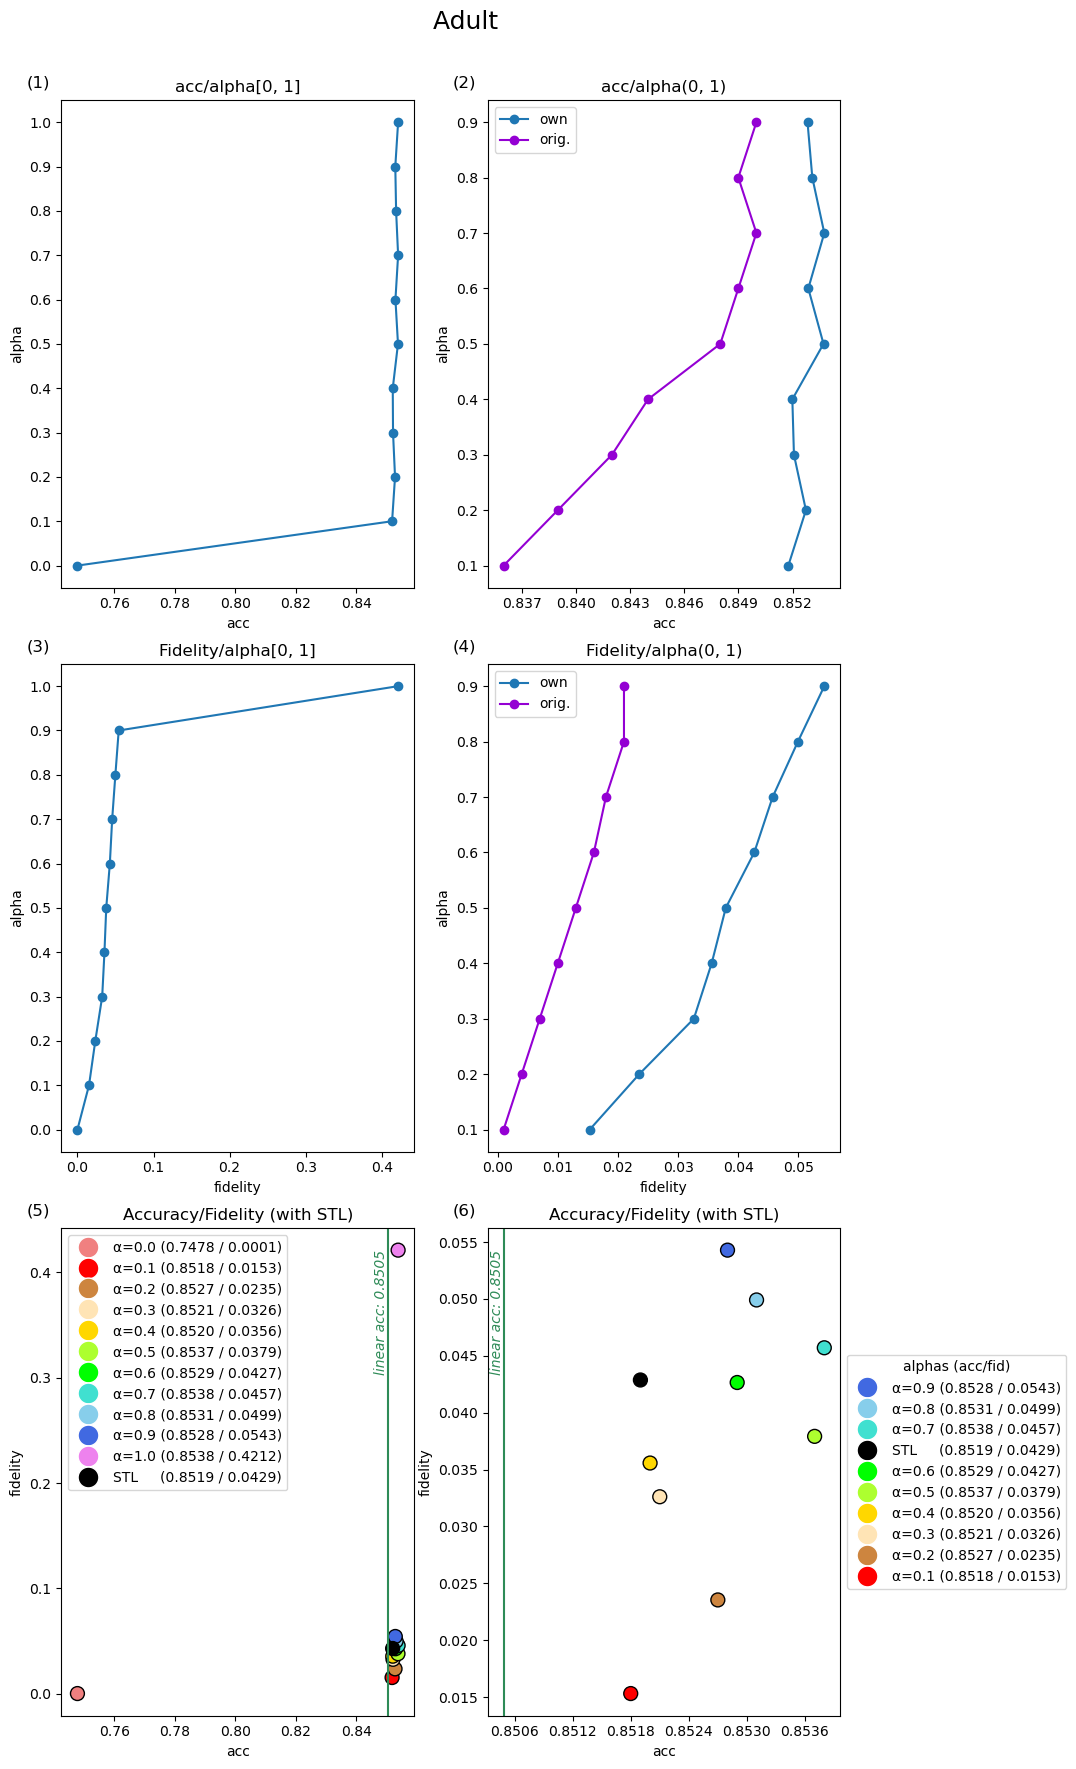

In [457]:
adult_org_results_met = [0.836,0.839,0.842,0.844,0.848,0.849,0.850,0.849,0.850]
adult_org_results_gf = [0.001,0.004,0.007,0.010,0.013,0.016,0.018,0.021,0.021]

draw_plots_MTL_vs_STL(
    metrics_label='acc',
    metrics_title='Accuracy',
    config=adult_cfg,
    org_met=adult_org_results_met,
    org_fid=adult_org_results_gf,
    title='Adult    '
)

### Local Explainability Evaluation

Creating Explainer

In [260]:
adult_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=adult_X_train_np,
    mode='classification',
    feature_names=adult_cfg.features.names,
    verbose=False,
    class_names=['below 50k', 'above 50k'],
    categorical_features=adult_cfg.features.categorical_indices,
    categorical_names=adult_cfg.features.values_names,
    discretize_continuous=False
)
adult_explainer

Global Neighborhood Fidelity for STL MLP

In [264]:
# load model
mlp = MLP_cls(input_size=adult_cfg.input_size, hidden_sizes=MLP_cls.get_hidden_sizes(adult_cfg.best_parameters, adult_cfg)).to(adult_cfg.device)
mlp.load_state_dict(torch.load(adult_cfg.models.mlp_opt + '0' + adult_cfg.models.ext))

# prediction function
adult_predict_lime = partial(predict_cls_for_lime, model=mlp, config=adult_cfg)

# neighbors dataset
num_rows = 500
adult_indices = torch.randperm(adult_X_test_np.shape[0])[:num_rows]
adult_neighbors_dataset = adult_X_test_np[adult_indices]
print(adult_neighbors_dataset.shape)


adult_cfg.results.stl_gnf = global_neighborhood_fidelity_cls(
    model=mlp,
    neighbors_dataset=adult_neighbors_dataset,
    explainer=adult_explainer,
    config=adult_cfg,
    predict_func_lime=adult_predict_lime,
    predict_func_model=predict_cls_for_lime,
    n=adult_cfg.num
)
adult_cfg.results.stl_gnf

(500, 13)


[tensor(0.2130),
 tensor(0.1984),
 tensor(0.2128),
 tensor(0.2022),
 tensor(0.2026)]

Global Neighborhood Fidelity for MTL

In [265]:
gnf_mtl_cls_n_times(
    neighbors_dataset=adult_neighbors_dataset,
    explainer=adult_explainer,
    model_params=adult_cfg.best_parameters,
    config=adult_cfg,
    n=adult_cfg.num
)

Model for alpha: 0.0
Model: Adult/mtl_alpha_0.0_0.pt, GNF: [tensor(0.0002)]
Model for alpha: 0.1
Model: Adult/mtl_alpha_0.1_0.pt, GNF: [tensor(0.1428)]
Model for alpha: 0.2
Model: Adult/mtl_alpha_0.2_0.pt, GNF: [tensor(0.1228)]
Model for alpha: 0.3
Model: Adult/mtl_alpha_0.3_0.pt, GNF: [tensor(0.1458)]
Model for alpha: 0.4
Model: Adult/mtl_alpha_0.4_0.pt, GNF: [tensor(0.1356)]
Model for alpha: 0.5
Model: Adult/mtl_alpha_0.5_0.pt, GNF: [tensor(0.1668)]
Model for alpha: 0.6
Model: Adult/mtl_alpha_0.6_0.pt, GNF: [tensor(0.1286)]
Model for alpha: 0.7
Model: Adult/mtl_alpha_0.7_0.pt, GNF: [tensor(0.2774)]
Model for alpha: 0.8
Model: Adult/mtl_alpha_0.8_0.pt, GNF: [tensor(0.1846)]
Model for alpha: 0.9
Model: Adult/mtl_alpha_0.9_0.pt, GNF: [tensor(0.1128)]
Model for alpha: 1.0
Model: Adult/mtl_alpha_1.0_0.pt, GNF: [tensor(0.1696)]
Model for alpha: 0.0
Model: Adult/mtl_alpha_0.0_0.pt, GNF: [tensor(0.)]
Model for alpha: 0.1
Model: Adult/mtl_alpha_0.1_0.pt, GNF: [tensor(0.1420)]
Model for alpha:

In [266]:
show_tables_lime(adult_cfg) 

Metric,Dataset,Linear,STL,MTL a= 0.0,MTL a= 0.1,MTL a= 0.2,MTL a= 0.3,MTL a= 0.4,MTL a= 0.5,MTL a= 0.6,MTL a= 0.7,MTL a= 0.8,MTL a= 0.9,MTL a= 1.0
GNF,Adult,-,"0,206","0,000","0,141","0,126","0,149","0,139","0,163","0,124","0,276","0,180","0,113","0,166"
ACC,Adult,"0,851","0,851","0,748","0,850","0,853","0,853","0,853","0,852","0,849","0,855","0,852","0,852","0,856"


## Titanic

### Preparation

#### Configuration Settings

In [100]:
titanic_cfg = Config(
    folders=Folders(base="Titanic/"),
    files=Files(
        data="titanic_data.pkl", 
        targets="titanic_targets.pkl", 
        study='Titanic.plt'
    ),
    training=Training(batch_size=64, num_epochs=500, patience=24),
    tuning=Tuning(num_trials = 50),
)

#### Data Loading and Standardization

In [101]:
# Data Loading
titanic_df = pd.read_pickle(titanic_cfg.paths.data)

titanic_cfg.features.numerical = titanic_df.select_dtypes(include='number').columns.values.tolist()
titanic_cfg.features.numerical_indices = [titanic_df.columns.get_loc(feature) for feature in titanic_cfg.features.numerical]
titanic_cfg.features.categorical = titanic_df.select_dtypes(include='object').columns.values.tolist()
titanic_cfg.features.categorical_indices = [titanic_df.columns.get_loc(feature) for feature in titanic_cfg.features.categorical]
titanic_cfg.features.names = titanic_df.columns.values.tolist()


# Creating Dictionary 
titanic_cfg.features.values_names = {}
for feature, idx in zip(titanic_cfg.features.categorical, titanic_cfg.features.categorical_indices):
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(titanic_df[feature])
    titanic_df[feature] = le.transform(titanic_df[feature])
    titanic_cfg.features.values_names[idx] = le.classes_
    
# Data Splitting
titanic_X_train, titanic_X_test, titanic_y_train, titanic_y_test = train_test_split(
    titanic_df,
    np.array(pd.read_pickle(titanic_cfg.paths.targets)), 
    test_size=0.2, 
    random_state=42
)

titanic_X_eval, titanic_X_test, titanic_y_eval, titanic_y_test = train_test_split(
    titanic_X_test, 
    titanic_y_test, 
    test_size=0.5, 
    random_state=42
)

# Data Scaling
titanic_scaler = StandardScaler()
titanic_X_train[titanic_cfg.features.numerical] = titanic_scaler.fit_transform(titanic_X_train[titanic_cfg.features.numerical]).astype(float)
titanic_X_train[titanic_cfg.features.categorical] = titanic_X_train[titanic_cfg.features.categorical].astype(float)

titanic_X_eval[titanic_cfg.features.numerical] = titanic_scaler.transform(titanic_X_eval[titanic_cfg.features.numerical]).astype(float)
titanic_X_eval[titanic_cfg.features.categorical] = titanic_X_eval[titanic_cfg.features.categorical].astype(float)

titanic_X_test[titanic_cfg.features.numerical] = titanic_scaler.transform(titanic_X_test[titanic_cfg.features.numerical]).astype(float)
titanic_X_test[titanic_cfg.features.categorical] = titanic_X_test[titanic_cfg.features.categorical].astype(float)

# Data Encoding with reindexing to maintain uniform number of columns
titanic_cfg.features.dummy = pd.get_dummies(titanic_df.astype(float), columns=titanic_cfg.features.categorical, dtype=float).columns 

titanic_X_train_encoded = pd.get_dummies(titanic_X_train, columns=titanic_cfg.features.categorical, dtype=float)
titanic_X_train_encoded = titanic_X_train_encoded.reindex(columns=titanic_cfg.features.dummy, fill_value=0.0).values

titanic_X_eval_encoded = pd.get_dummies(titanic_X_eval, columns=titanic_cfg.features.categorical, dtype=float)
titanic_X_eval_encoded = titanic_X_eval_encoded.reindex(columns=titanic_cfg.features.dummy, fill_value=0.0).values

titanic_X_test_encoded = pd.get_dummies(titanic_X_test, columns=titanic_cfg.features.categorical, dtype=float)
titanic_X_test_encoded = titanic_X_test_encoded.reindex(columns=titanic_cfg.features.dummy, fill_value=0.0).values

# Data Conversion 
titanic_X_train_tensor = torch.tensor(titanic_X_train_encoded, dtype=torch.float32)
titanic_X_eval_tensor = torch.tensor(titanic_X_eval_encoded, dtype=torch.float32)
titanic_X_test_tensor = torch.tensor(titanic_X_test_encoded, dtype=torch.float32)

titanic_y_train_tensor = torch.tensor(titanic_y_train, dtype=torch.float32)
titanic_y_eval_tensor = torch.tensor(titanic_y_eval, dtype=torch.float32)
titanic_y_test_tensor = torch.tensor(titanic_y_test, dtype=torch.float32)

titanic_X_train_np = titanic_X_train.values
titanic_X_eval_np = titanic_X_eval.values
titanic_X_test_np = titanic_X_test.values

# Updating Configuration 
titanic_cfg.input_size = titanic_X_train_tensor.shape[1]
titanic_cfg.tuning.min_neurons = titanic_cfg.input_size // 4 - 1
titanic_cfg.tuning.max_neurons = titanic_cfg.input_size * 4 + 1

### Finding Best MLP model

#### Optimization Function

In [102]:
def train_and_optimize_titanic(trial, config: Config):
    print(f"Trial: {trial}")
    num_layers = trial.suggest_int(config.tuning.name_layers, config.tuning.min_layers, config.tuning.max_layers)
    hidden_sizes = [trial.suggest_int(f'{config.tuning.name_neurons}{i}', config.tuning.min_neurons, config.tuning.max_neurons) for i in range(num_layers)]

    model = MLP_cls(config.input_size, hidden_sizes, 1)

    acc = train_eval(
        data_train=titanic_X_train_tensor,
        target_train=titanic_y_train_tensor,
        data_eval=titanic_X_eval_tensor,
        target_eval=titanic_y_eval_tensor,
        model=model,
        criterion_train=BCELoss(),
        criterion_eval=AccuracyScore(),
        eval_func=eval_cls,
        direction='max',
        config=config
    )
    return acc

#### Model Optimization

In [152]:
def study_titanic(config: Config):
    objective = partial(train_and_optimize_titanic, config=config)
    study = optuna.create_study(
        study_name=config.files.study, 
        sampler=config.tuning.sampler(), 
        direction='maximize', 
    )
    study.optimize(objective, n_trials=config.tuning.num_trials, show_progress_bar=True)
    joblib.dump(study, config.paths.study)
    return study

titanic_study = try_load_study(study_titanic, titanic_cfg)

In [158]:
titanic_study.trials_dataframe().sort_values("value", ascending=False).drop(['datetime_start', 'datetime_complete'], axis=1).head(5)

,number,value,duration,params_num_layers,params_num_neurons0,params_num_neurons1,params_num_neurons2,params_num_neurons3,params_num_neurons4,state
44,44,0.793893,0 days 00:00:06.046427,4,7,39.0,45.0,43.0,NaN,COMPLETE
9,9,0.793893,0 days 00:00:02.251064,3,20,47.0,40.0,NaN,NaN,COMPLETE
15,15,0.786260,0 days 00:00:04.866650,4,9,37.0,20.0,5.0,NaN,COMPLETE
28,28,0.786260,0 days 00:00:02.412571,5,6,40.0,34.0,31.0,25.0,COMPLETE
34,34,0.786260,0 days 00:00:02.244581,3,11,41.0,18.0,NaN,NaN,COMPLETE


Due to the same result in accuracy and I choose the model from trial number nine, to speed up further training.

In [105]:
# study.best_params
print(titanic_study.trials[9].value)

titanic_cfg.best_parameters = titanic_study.trials[9].params
titanic_cfg.best_parameters

0.7938931584358215


{'num_layers': 3, 'num_neurons0': 20, 'num_neurons1': 47, 'num_neurons2': 40}

### Training and Testing MLP

In [106]:
train_and_test_mlp_cls(
    X_train=titanic_X_train_tensor, 
    y_train=titanic_y_train_tensor,
    X_eval=titanic_X_eval_tensor, 
    y_eval=titanic_y_eval_tensor, 
    X_test=titanic_X_test_tensor, 
    y_test=titanic_y_test_tensor, 
    config=titanic_cfg
)
print(np.mean(list(titanic_cfg.results.stl_mlp.values())))
titanic_cfg.results.stl_mlp

Model Titanic/mlp_opt_0.pt loaded successfully
Model Titanic/mlp_opt_1.pt loaded successfully
Model Titanic/mlp_opt_2.pt loaded successfully
Model Titanic/mlp_opt_3.pt loaded successfully
Model Titanic/mlp_opt_4.pt loaded successfully
0.7816793918609619


{0: 0.7709923982620239,
 1: 0.8015267252922058,
 2: 0.7480915784835815,
 3: 0.7862595319747925,
 4: 0.8015267252922058}

### Training and Testing Linear Model

In [107]:
train_and_test_lin_cls(
    X_train=titanic_X_train_tensor, 
    y_train=titanic_y_train_tensor,
    X_eval=titanic_X_eval_tensor, 
    y_eval=titanic_y_eval_tensor, 
    X_test=titanic_X_test_tensor, 
    y_test=titanic_y_test_tensor, 
    config=titanic_cfg
)
print(np.mean(list(titanic_cfg.results.reg.values())))
titanic_cfg.results.reg

Model Titanic/reg_0.pt loaded successfully
Model Titanic/reg_1.pt loaded successfully
Model Titanic/reg_2.pt loaded successfully
Model Titanic/reg_3.pt loaded successfully
Model Titanic/reg_4.pt loaded successfully
0.7374045848846436


{0: 0.7557252049446106,
 1: 0.7557252049446106,
 2: 0.7480915784835815,
 3: 0.694656491279602,
 4: 0.732824444770813}

### Training and Testing STL Surogate Model

Train Logistic Regression to explain adult_mlp_stl model

In [108]:
train_and_test_stl_lin_cls(
    X_train=titanic_X_train_tensor, 
    X_eval=titanic_X_eval_tensor, 
    X_test=titanic_X_test_tensor, 
    config=titanic_cfg
)
print(np.mean(list(titanic_cfg.results.stl_reg.values())))
titanic_cfg.results.stl_reg

Model Titanic/stl_reg_0.pt loaded successfully
Model Titanic/stl_reg_1.pt loaded successfully
Model Titanic/stl_reg_2.pt loaded successfully
Model Titanic/stl_reg_3.pt loaded successfully
Model Titanic/stl_reg_4.pt loaded successfully
0.03816793896257877


{0: 0.04580152779817581,
 1: 0.022900763899087906,
 2: 0.05343511328101158,
 3: 0.038167938590049744,
 4: 0.030534351244568825}

### Training and Testing Models in MTL Approach 

MLP + LinReg, alpha in the range of 0 to 1 with a step of 0.1.

In [109]:
train_and_test_mtl_cls(
    X_train=titanic_X_train_tensor,
    y_train=titanic_y_train_tensor,
    X_eval=titanic_X_eval_tensor, 
    y_eval=titanic_y_eval_tensor, 
    X_test=titanic_X_test_tensor, 
    y_test=titanic_y_test_tensor, 
    config=titanic_cfg
)
titanic_cfg.results.mtl

Model for alpha: 0.0
Model Titanic/mtl_alpha_0.0_0.pt loaded successfully
Result on test dataset: Titanic/mtl_alpha_0.0_0.pt, Accuracy: 0.4580152630805969, Fidelity: 0.015267175622284412
Model for alpha: 0.1
Model Titanic/mtl_alpha_0.1_0.pt loaded successfully
Result on test dataset: Titanic/mtl_alpha_0.1_0.pt, Accuracy: 0.7557252049446106, Fidelity: 0.030534351244568825
Model for alpha: 0.2
Model Titanic/mtl_alpha_0.2_0.pt loaded successfully
Result on test dataset: Titanic/mtl_alpha_0.2_0.pt, Accuracy: 0.7709923982620239, Fidelity: 0.030534351244568825
Model for alpha: 0.3
Model Titanic/mtl_alpha_0.3_0.pt loaded successfully
Result on test dataset: Titanic/mtl_alpha_0.3_0.pt, Accuracy: 0.7633587718009949, Fidelity: 0.05343511328101158
Model for alpha: 0.4
Model Titanic/mtl_alpha_0.4_0.pt loaded successfully
Result on test dataset: Titanic/mtl_alpha_0.4_0.pt, Accuracy: 0.8015267252922058, Fidelity: 0.05343511328101158
Model for alpha: 0.5
Model Titanic/mtl_alpha_0.5_0.pt loaded succes

{0: {'0.0': Result(metrics=0.4580152630805969, fid=0.015267175622284412),
  '0.1': Result(metrics=0.7557252049446106, fid=0.030534351244568825),
  '0.2': Result(metrics=0.7709923982620239, fid=0.030534351244568825),
  '0.3': Result(metrics=0.7633587718009949, fid=0.05343511328101158),
  '0.4': Result(metrics=0.8015267252922058, fid=0.05343511328101158),
  '0.5': Result(metrics=0.7862595319747925, fid=0.038167938590049744),
  '0.6': Result(metrics=0.8091602921485901, fid=0.05343511328101158),
  '0.7': Result(metrics=0.7862595319747925, fid=0.09160305559635162),
  '0.8': Result(metrics=0.7938931584358215, fid=0.09160305559635162),
  '0.9': Result(metrics=0.7938931584358215, fid=0.022900763899087906),
  '1.0': Result(metrics=0.7938931584358215, fid=0.6259542107582092)},
 1: {'0.0': Result(metrics=0.38167938590049744, fid=0.0),
  '0.1': Result(metrics=0.7557252049446106, fid=0.022900763899087906),
  '0.2': Result(metrics=0.7557252049446106, fid=0.05343511328101158),
  '0.3': Result(metrics

### Comparison of STL with MTL

In [143]:
titanic_cfg.metrics_label = 'ACC'
show_tables(titanic_cfg) 

Metric,Dataset,Linear,Non-linear (MLP)
ACC,Titanic,"0,7374","0,7817"


Metric,Dataset,Linear,STL,MTL a= 0.0,MTL a= 0.1,MTL a= 0.2,MTL a= 0.3,MTL a= 0.4,MTL a= 0.5,MTL a= 0.6,MTL a= 0.7,MTL a= 0.8,MTL a= 0.9,MTL a= 1.0
ACC,Titanic,"0,7374","0,7817","0,4458","0,7649","0,7603","0,7740","0,7893","0,7847","0,7908","0,7893","0,7939","0,7878","0,7908"
Global Fidelity,Titanic,-,"0,0382","0,0107","0,0275","0,0473","0,0519","0,0641","0,0504","0,0382","0,0504","0,0916","0,1634","0,6656"


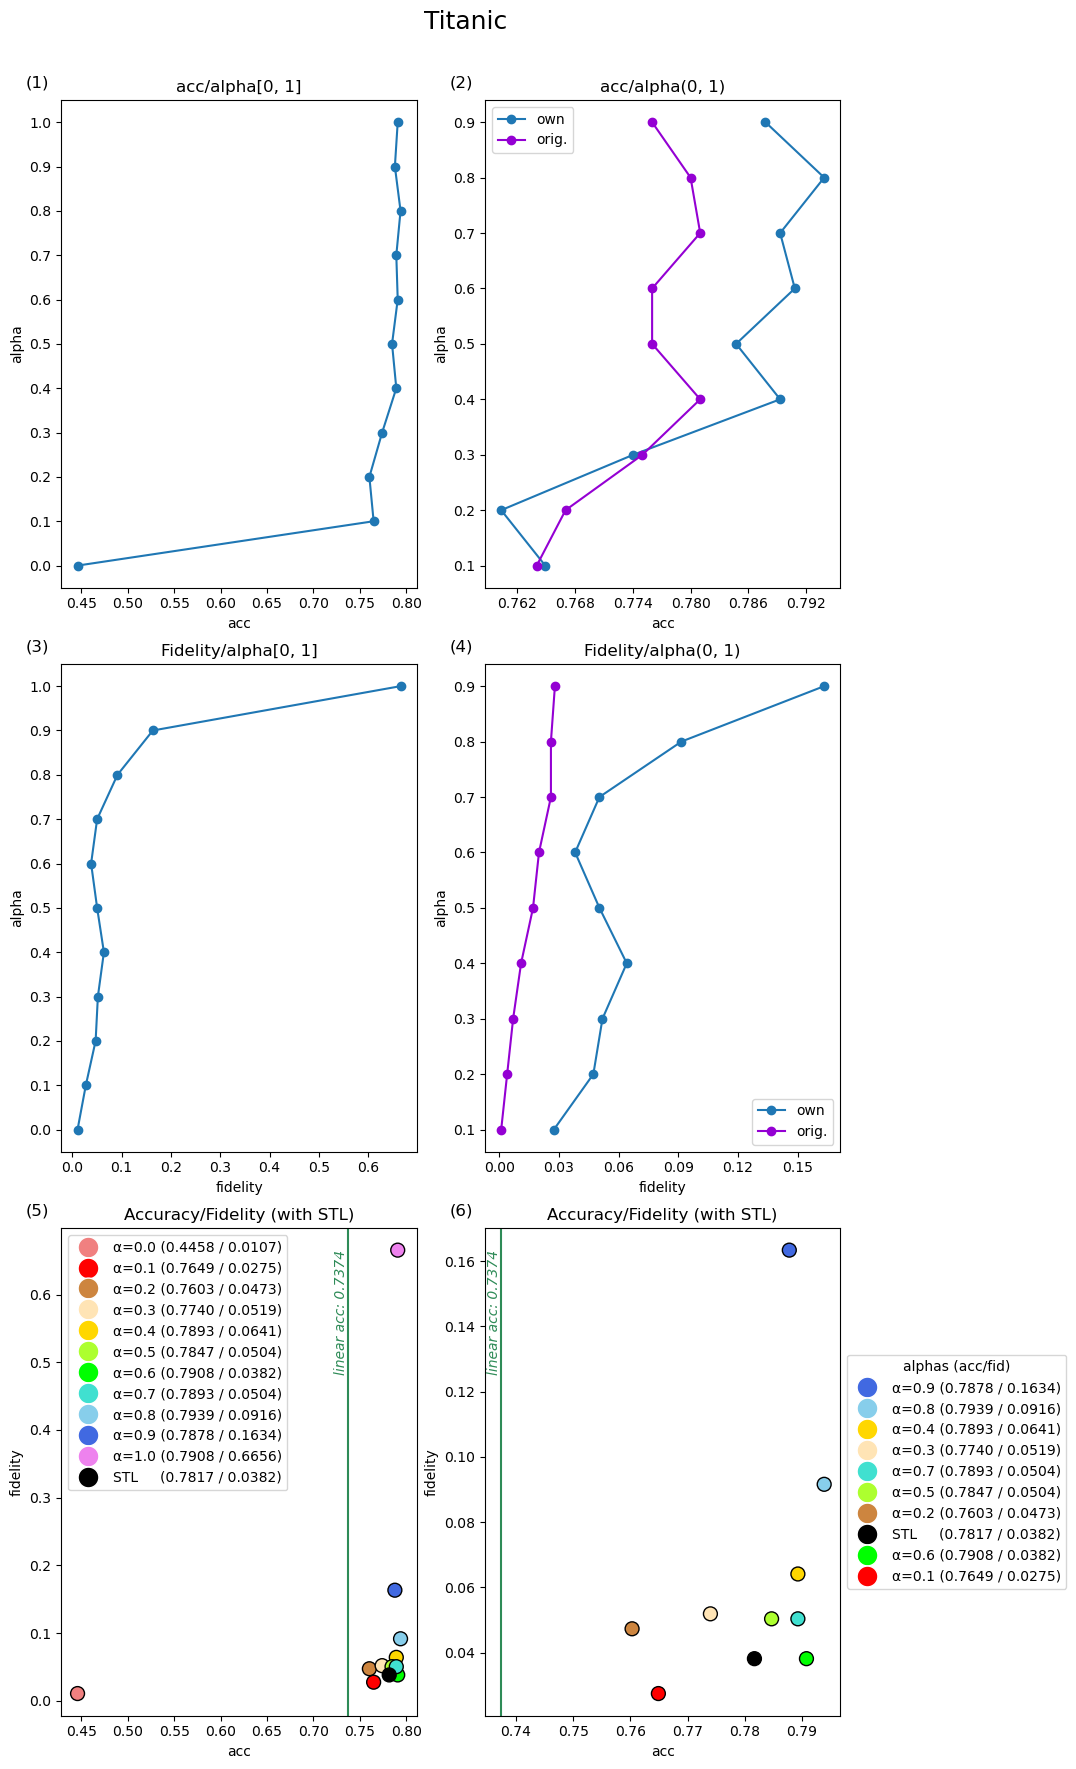

In [460]:
titanic_org_results_met = [0.764, 0.767, 0.775, 0.781, 0.776, 0.776, 0.781, 0.780, 0.776]
titanic_org_results_gf = [0.001, 0.004, 0.007, 0.011, 0.017, 0.020, 0.026, 0.026, 0.028]

draw_plots_MTL_vs_STL(
    metrics_label='acc',
    metrics_title='Accuracy',
    config=titanic_cfg,
    org_met=titanic_org_results_met,
    org_fid=titanic_org_results_gf,
    title='Titanic    '
)

### Local Explainability Evaluation

Creating Explainer

In [112]:
titanic_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=titanic_X_train_np,
    mode='classification',
    feature_names=titanic_cfg.features.names,
    verbose=False,
    class_names=['not survived', 'survived'],
    categorical_features=titanic_cfg.features.categorical_indices,
    categorical_names=titanic_cfg.features.values_names,
    discretize_continuous=False
)
titanic_explainer

Global Neighborhood Fidelity for STL MLP

In [121]:
# load model
mlp = MLP_cls(input_size=titanic_cfg.input_size, hidden_sizes=MLP_cls.get_hidden_sizes(titanic_cfg.best_parameters, titanic_cfg)).to(titanic_cfg.device)
mlp.load_state_dict(torch.load(titanic_cfg.models.mlp_opt + '0' + titanic_cfg.models.ext))

# prediction function
titanic_predict_lime = partial(predict_cls_for_lime, model=mlp, config=titanic_cfg)

# neighbors dataset
print(titanic_X_test_np.shape)


titanic_cfg.results.stl_gnf = global_neighborhood_fidelity_cls(
    model=mlp,
    neighbors_dataset=titanic_X_test_np,
    explainer=titanic_explainer,
    config=titanic_cfg,
    predict_func_lime=titanic_predict_lime,
    predict_func_model=predict_cls_for_lime,
    n=titanic_cfg.num
)
titanic_cfg.results.stl_gnf

(131, 7)


[tensor(0.3275),
 tensor(0.3336),
 tensor(0.3344),
 tensor(0.3351),
 tensor(0.3321)]

Global Neighborhood Fidelity for MTL

In [117]:
gnf_mtl_cls_n_times(
    neighbors_dataset=titanic_X_test_np,
    explainer=titanic_explainer,
    model_params=titanic_cfg.best_parameters,
    config=titanic_cfg
)

Model for alpha: 0.0
Model: Titanic/mtl_alpha_0.0_0.pt, GNF: [tensor(0.0664)]
Model for alpha: 0.1
Model: Titanic/mtl_alpha_0.1_0.pt, GNF: [tensor(0.2725)]
Model for alpha: 0.2
Model: Titanic/mtl_alpha_0.2_0.pt, GNF: [tensor(0.3336)]
Model for alpha: 0.3
Model: Titanic/mtl_alpha_0.3_0.pt, GNF: [tensor(0.2580)]
Model for alpha: 0.4
Model: Titanic/mtl_alpha_0.4_0.pt, GNF: [tensor(0.3542)]
Model for alpha: 0.5
Model: Titanic/mtl_alpha_0.5_0.pt, GNF: [tensor(0.3672)]
Model for alpha: 0.6
Model: Titanic/mtl_alpha_0.6_0.pt, GNF: [tensor(0.3618)]
Model for alpha: 0.7
Model: Titanic/mtl_alpha_0.7_0.pt, GNF: [tensor(0.3489)]
Model for alpha: 0.8
Model: Titanic/mtl_alpha_0.8_0.pt, GNF: [tensor(0.3229)]
Model for alpha: 0.9
Model: Titanic/mtl_alpha_0.9_0.pt, GNF: [tensor(0.3473)]
Model for alpha: 1.0
Model: Titanic/mtl_alpha_1.0_0.pt, GNF: [tensor(0.3069)]
Model for alpha: 0.0
Model: Titanic/mtl_alpha_0.0_0.pt, GNF: [tensor(0.0649)]
Model for alpha: 0.1
Model: Titanic/mtl_alpha_0.1_0.pt, GNF: [te

In [134]:
get_prediction_results(titanic_cfg)

,Metric,Dataset,Linear,STL,MTL a= 0.0,MTL a= 0.1,MTL a= 0.2,MTL a= 0.3,MTL a= 0.4,MTL a= 0.5,MTL a= 0.6,MTL a= 0.7,MTL a= 0.8,MTL a= 0.9,MTL a= 1.0
0,ACC,Titanic,0.755725,0.770992,0.458015,0.755725,0.770992,0.763359,0.801527,0.78626,0.80916,0.78626,0.793893,0.793893,0.793893


In [269]:
show_tables_lime(titanic_cfg) 

Metric,Dataset,Linear,STL,MTL a= 0.0,MTL a= 0.1,MTL a= 0.2,MTL a= 0.3,MTL a= 0.4,MTL a= 0.5,MTL a= 0.6,MTL a= 0.7,MTL a= 0.8,MTL a= 0.9,MTL a= 1.0
GNF,Titanic,-,"0,333","0,072","0,270","0,333","0,259","0,355","0,368","0,359","0,348","0,319","0,346","0,298"
ACC,Titanic,"0,756","0,771","0,458","0,756","0,771","0,763","0,802","0,786","0,809","0,786","0,794","0,794","0,794"


## Summary of Results

### Linear and Non-linear models comparison

In [220]:
configs = [auto_cfg, housing_cfg, wine_cfg, adult_cfg, titanic_cfg]
auto_cfg.metrics_label = 'MSE'
housing_cfg.metrics_label = 'MSE'
wine_cfg.metrics_label = 'MSE'
adult_cfg.metrics_label = 'ACC'
titanic_cfg.metrics_label = 'ACC'

results_lin_vs_non_lin = []
for config in configs:
    results_lin_vs_non_lin.append(get_results_non_lin_vs_lin(config))
results_lin_vs_non_lin = pd.concat(results_lin_vs_non_lin)

display(results_lin_vs_non_lin.style.format(precision=4, decimal=",").hide())
results_lin_vs_non_lin.to_csv("results_lin_vs_non_lin_0.csv")

Metrics,Dataset,Linear,Non-linear (MLP)
MSE,Auto,"0,1572","0,0872"
MSE,Housing,"0,3662","0,2006"
MSE,Wine,"0,6557","0,6265"
ACC,Adult,"0,8505","0,8519"
ACC,Titanic,"0,7374","0,7817"


### MTL and STL approaches comparison

In [227]:
configs = [auto_cfg, housing_cfg, wine_cfg, adult_cfg, titanic_cfg]

results_stl_vs_mtl = []
for config in configs:
    results_stl_vs_mtl.append(get_results_mtl_vs_stl(config))
results_stl_vs_mtl = pd.concat(results_stl_vs_mtl)

display(results_stl_vs_mtl.style.format(precision=4, decimal=",").hide())
results_stl_vs_mtl.to_csv("results_stl_vs_mtl_0.csv")


Metrics,Dataset,Linear,STL,MTL a= 0.0,MTL a= 0.1,MTL a= 0.2,MTL a= 0.3,MTL a= 0.4,MTL a= 0.5,MTL a= 0.6,MTL a= 0.7,MTL a= 0.8,MTL a= 0.9,MTL a= 1.0
MSE,Auto,"0,1572","0,0872","1,1589","0,1601","0,1459","0,1415","0,1280","0,1144","0,0933","0,0927","0,0849","0,0827","0,0962"
Global Fidelity,Auto,-,"0,1275","0,0001","0,0006","0,0016","0,0032","0,0073","0,0128","0,0211","0,0319","0,0538","0,0831","1,5249"
MSE,Housing,"0,3662","0,2006","1,1424","0,3541","0,3405","0,3224","0,3062","0,2863","0,2658","0,2398","0,2173","0,2049","0,2017"
Global Fidelity,Housing,-,"0,1699","0,0000","0,0003","0,0013","0,0036","0,0073","0,0135","0,0244","0,0435","0,0726","0,1157","1,0664"
MSE,Wine,"0,6557","0,6265","1,2660","0,6521","0,6410","0,6402","0,6255","0,6279","0,6124","0,6211","0,6244","0,6128","0,6313"
Global Fidelity,Wine,-,"0,0695","0,0000","0,0008","0,0018","0,0045","0,0083","0,0166","0,0241","0,0323","0,0548","0,0596","1,1165"
ACC,Adult,"0,8505","0,8519","0,7478","0,8518","0,8527","0,8521","0,8520","0,8537","0,8529","0,8538","0,8531","0,8528","0,8538"
Global Fidelity,Adult,-,"0,0429","0,0001","0,0153","0,0235","0,0326","0,0356","0,0379","0,0427","0,0457","0,0499","0,0543","0,4212"
ACC,Titanic,"0,7374","0,7817","0,4458","0,7649","0,7603","0,7740","0,7893","0,7847","0,7908","0,7893","0,7939","0,7878","0,7908"
Global Fidelity,Titanic,-,"0,0382","0,0107","0,0275","0,0473","0,0519","0,0641","0,0504","0,0382","0,0504","0,0916","0,1634","0,6656"


###	MTL and STL comparison in field of local explainability 

In [268]:
configs = [auto_cfg, housing_cfg, wine_cfg, adult_cfg, titanic_cfg]

results_stl_vs_mtl_gnf = []
for config in configs:
    results_stl_vs_mtl_gnf.append(get_gnf_and_metrics(config))
results_stl_vs_mtl_gnf = pd.concat(results_stl_vs_mtl_gnf)

display(results_stl_vs_mtl_gnf.style.format(precision=4, decimal=",").hide())
results_stl_vs_mtl_gnf.to_csv("results_stl_vs_mtl_gnf_0.csv")

Metric,Dataset,Linear,STL,MTL a= 0.0,MTL a= 0.1,MTL a= 0.2,MTL a= 0.3,MTL a= 0.4,MTL a= 0.5,MTL a= 0.6,MTL a= 0.7,MTL a= 0.8,MTL a= 0.9,MTL a= 1.0
GNF,Auto,-,"0,1874","0,0287","0,0463","0,0713","0,0634","0,0723","0,0555","0,1147","0,0866","0,1340","0,1413","0,1512"
MSE,Auto,"0,1572","0,0818","0,9540","0,1698","0,1410","0,1288","0,1181","0,1242","0,0887","0,0996","0,0832","0,0791","0,0842"
GNF,Housing,-,"0,6729","0,0014","0,3123","0,3232","0,3240","0,3550","0,3935","0,4416","0,4512","0,5655","0,5915","0,8545"
MSE,Housing,"0,3656","0,2080","0,9553","0,3535","0,3389","0,3213","0,3035","0,2869","0,2623","0,2361","0,2150","0,2090","0,2042"
GNF,Wine,-,"0,1620","0,0076","0,0503","0,0497","0,0539","0,0559","0,0601","0,0998","0,0931","0,1211","0,1264","0,0957"
MSE,Wine,"0,6488","0,6445","1,3788","0,6471","0,6389","0,6265","0,6205","0,6108","0,6177","0,6078","0,6152","0,6026","0,6000"
GNF,Adult,-,"0,2058","0,0001","0,1412","0,1255","0,1492","0,1390","0,1633","0,1240","0,2762","0,1795","0,1130","0,1657"
ACC,Adult,"0,8507","0,8513","0,7485","0,8498","0,8527","0,8531","0,8533","0,8515","0,8489","0,8551","0,8522","0,8524","0,8560"
GNF,Titanic,-,"0,3325","0,0721","0,2702","0,3330","0,2592","0,3548","0,3682","0,3591","0,3478","0,3186","0,3461","0,2976"
ACC,Titanic,"0,7557","0,7710","0,4580","0,7557","0,7710","0,7634","0,8015","0,7863","0,8092","0,7863","0,7939","0,7939","0,7939"


In [382]:
import dill
dill.dump_session('notebook_env_2.db')